# Stratospheric Polar Vortex Diagnostics: An analysis with Numeric Weather Predictions
This notebook demonstrates the application of the *arctic* Python package to analyze the geometry and dynamics of the stratospheric polar vortex (SPV). The focus is on an analysis of the geometric vortex moments and their classification. The methodology aligns closely to the one used by Hannachi et al. (2011) and is modified where deemed suitable.

# Table of Contents
- [Introduction](#introduction)
- [Data](#data)
    - [Differences to Hannachi et al. 2011](#differences-to-hannachi-et-al-2011)
- [Methodology](#methodology)
    - [Reconstruction of same conditions as H11](#reconstruction-of-same-conditions-as-h11)
    - [Scaling](#scaling)
    - [Seasonality](#seasonality)
        - [Durbin Watson Test](#durbin-watson-test)
        - [Autocorrelation Function](#autocorrelation-function)
        - [Extended Emirical Orthogonal Function](#extended-empirical-orthogonal-function)
        - [Single Spectrum Analysis](#single-spectrum-analysis)
    - [Gap statistic](#gap-statistic)
    - [Hierarchical clustering](#hierarchical-clustering)
- [Results](#results)
    - [Statistical Profiles of Clusters](#statistical-profiles-of-clusters)
    - [Physical Interpretation and Literature Comparison](#physical-interpretation-and-literature-comparison)
- [Appendix](#appendix)
    - [Partial Autocorrelation](#computation-of-the-partial-autocorrelation-function)
    - [Year over Year Averages](#year-over-year-averages)
    - [Abbreviations](#abbreviations)

# Introduction
The stratospheric polar vortex (SPV) plays a central role in modulating mid-latitude weather patterns, particularly during winter. Sudden stratospheric warming (SSW) events, which can split or displace the vortex, are of great interest due to their impacts on the troposphere.

This study builds upon the methodology of Hannachi et al. (2011, hereafter H11), who used geometric moments derived from potential vorticity fields to characterize vortex morphology. Here, we apply similar techniques to the extracted features from ERA5 reanalysis data. We aim to replicate and assess H11's clustering results using elliptic indices.

# Data
The data used in this study were provided and preprocessed by the Institute of Atmospheric Physics (IAP) in Kühlungsborn. It includes daily diagnostics from the numerical weather predictions (nwp) of the Icosahedral Nonhydrostatic (ICON) general circulation model with upper atmosphere extension (UA-ICON), derived using the IDL-based ELDI and SSW packages. To be concrete, the data include the daily elliptic indices of the stratospheric polar vortex at 10hPa geopotential height and major warming diagnostics.

The data are split into three files:

- `*_cen.csv`: Contains event-centered diagnostics, including central SSW dates, i.e. when the wind reversed form westerly to easterly, persistence, maximum eastward wind, intensity, and accumulated intensity.
- `*_msw.csv`: Flags daily major warming events with corresponding zonally averaged wind speeds.
- `*_d.csv`: Includes daily geometric vortex diagnostics: area, centroid latitude/longitude (latcent, loncent), aspect ratio (ar), orientation angle (theta), and kurtosis. This file also marks split events (S) and includes diagnostics for identified sub-vortices, along with wave diagnostics at 60° latitude.

The dataset spans 1979–2040 and includes the same indices used in the full analysis demonstration of Hannachi et al. (2011). This analysis will focus on the following geometric moments: area, aspect ratio (ar), centroid latit

In [1]:
# import arctic in general
import arctic

# import other important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import specific functions from arcitc
from arctic.io.loader import read_data
from arctic.io.cleaner import no_white_space, to_date

# read data
era5_d = read_data("../data/SWXClust/NWP4A60/i4a60e2_d.csv")
era5_cen = read_data("../data/SWXClust/NWP4A60/i4a60m2t-cen.csv")
era5_msw = read_data("../data/SWXClust/NWP4A60/i4a60m2t-msw.csv")

# remove white space from column names
no_white_space(era5_d)
no_white_space(era5_cen)
no_white_space(era5_msw)

# change string to datetime for better comparison
to_date(era5_d, 'string', format='%d.%m.%Y-%H:%M:%S')
to_date(era5_cen, 'string', format='%d.%m.%Y-%H:%M')
to_date(era5_msw, 'string', format='%d.%m.%Y-%H:%M')

# convert columns to numeric
col_convert = [
    'area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1',
    'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'
]
era5_d[col_convert] = era5_d[col_convert].apply(pd.to_numeric, errors='coerce')
era5_d = era5_d.fillna(0)

# merge era5 data to one big dataframe
era5_all = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).\
    merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# handling string encodings
from sklearn.preprocessing import LabelEncoder
le_mw = LabelEncoder()
era5_all['MW'] = le_mw.fit_transform(era5_all.MW)
print(f"Transformed 'MW':\n{le_mw.inverse_transform([1])} to 1\n{le_mw.inverse_transform([0])} to 0")
le_form = LabelEncoder()
era5_all['form'] = le_form.fit_transform(era5_all.form)
print(f"Transformed 'form': \n {le_form.inverse_transform([1])} to 1\n{le_form.inverse_transform([0])} to 0")

# handling NaN values and string encodings
era5_all[era5_cen.columns[-4:]] = era5_all[era5_cen.columns[-4:]].fillna(0)

# drop constant columns
era5_all.drop(['D_d', 'level', 'hour',
               'D_cen', 'num', 'counter_cen', 'time_cen',
               'D_msw', 'counter_msw', 'time_msw'
               ], axis=1, inplace=True)
# sort by date
era5_all = era5_all.sort_values('string').reset_index(drop=True)

# check
era5_all.info()

Transformed 'MW':
['MW'] to 1
[''] to 0
Transformed 'form': 
 ['S'] to 1
['D'] to 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22462 entries, 0 to 22461
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   counter_d  22462 non-null  int64         
 1   time_d     22462 non-null  float64       
 2   string     22462 non-null  datetime64[ns]
 3   year       22462 non-null  int64         
 4   month      22462 non-null  int64         
 5   day        22462 non-null  int64         
 6   edge       22462 non-null  float64       
 7   form       22462 non-null  int64         
 8   area       22462 non-null  float64       
 9   obj_area   22462 non-null  float64       
 10  latcent    22462 non-null  float64       
 11  loncent    22462 non-null  float64       
 12  theta      22462 non-null  float64       
 13  ar         22462 non-null  float64       
 14  kurtosis   22462 non-null  float64       
 15  are

# Methodology
## Reconstruction of same conditions as H11
In H11, a winter period (december to march, DJFM) is selected and data range from 1958 to 2002. The authors note activity peaks in dec - jan and an oscillation period around 120-130d. As mentioned before, the ERA5 data are only after 1963 available. In the following diagrams, depicting a time series, the difference is marked by a dotted line. Everything to the left of this line should closely follow the results from H11 in the right part of their diagram.

With the selection of DJFM, there is a difference of 516 days which can not be displayed. The diagrams illustrate the consecutive days of DJFM. For a better orientation a second axis with the respective dates is added, though still all other month are skipped. Hence, March is followed by December.

## Scaling
Normalization broadly refers to any generic alteration of data making them more compatible (Gewers et al. 2021). Common approach are *MinMax* scaling, i.e. each feature has a given range $\left[min, max\right]$, or *Standard* scaling as given below, i.e. each variable has a mean of zero and variance of one.

$$x' = \frac{x-\mu}{\sigma}$$

It is not explicitly mentioned which methods were used for scaling. A look at the timeseries diagrams suggest a StandardScaler and can be well enough verified by the respective diagrams below.

## Time series of scaled AR, Latcent, Area and kurtosis
Due to the difference in data the first 1000 days could not be displayed as in H11. There is a difference of 516 days (i.e. day 484 in the diagram below corresponds to day 1000 in Figure 2 from Hannachi et al.). This is illustrated by the dotted line in the diagram.

Further it is unclear in which order the following steps where performed: scaling, selection of DJFM period.
Scaling first, then selecting DJFM does result in a different values then proceeding vice versa.
Form the resulting diagrams, it appears to be that the time period is first selected and then scaled. When first scaling, then selecting, the "baseline" of kurtosis seems to be slightly below 0.

In [3]:
from sklearn.preprocessing import StandardScaler

# scale on entire data
sc = StandardScaler()
era5_all = era5_all[era5_all['string'] < '02-05-2006'] # buffer for filtering with eeof: 400days
era5_all.loc[:,['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis', 'scaled_u']] = sc.fit_transform(era5_all[['area', 'ar', 'latcent', 'kurtosis','u']])

# time constraints
era5_winter = era5_all[(era5_all['string'] < '03-15-2006') &
                     (era5_all['month']).isin([12,1,2,3])]
era5_winter.reset_index(drop=True, inplace=True)

# only geometric moments + wind speed
era5_hannachi = era5_winter[['string', 'year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis', 'u']]
# scale on DJFM
era5_hannachi.loc[:, ['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis', 'scaled_u']] = sc.fit_transform(era5_hannachi[['area', 'ar', 'latcent', 'kurtosis', 'u']])

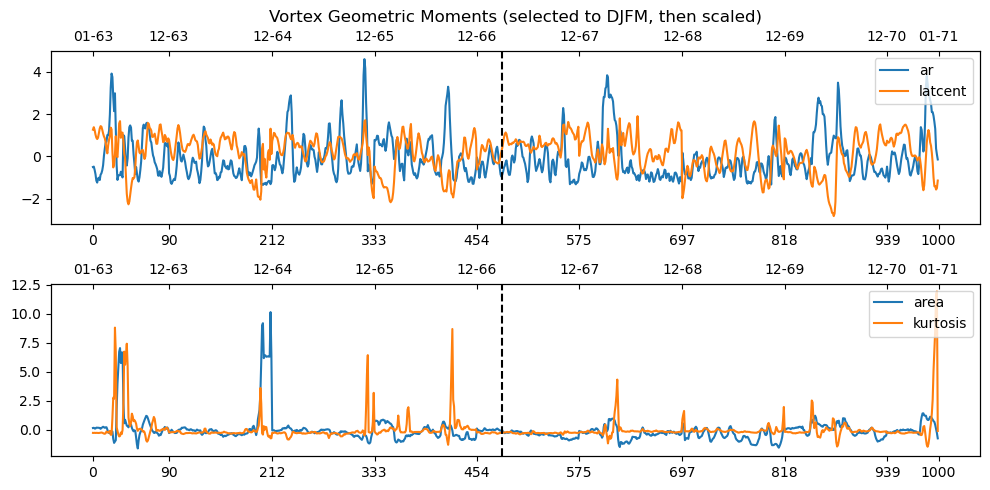

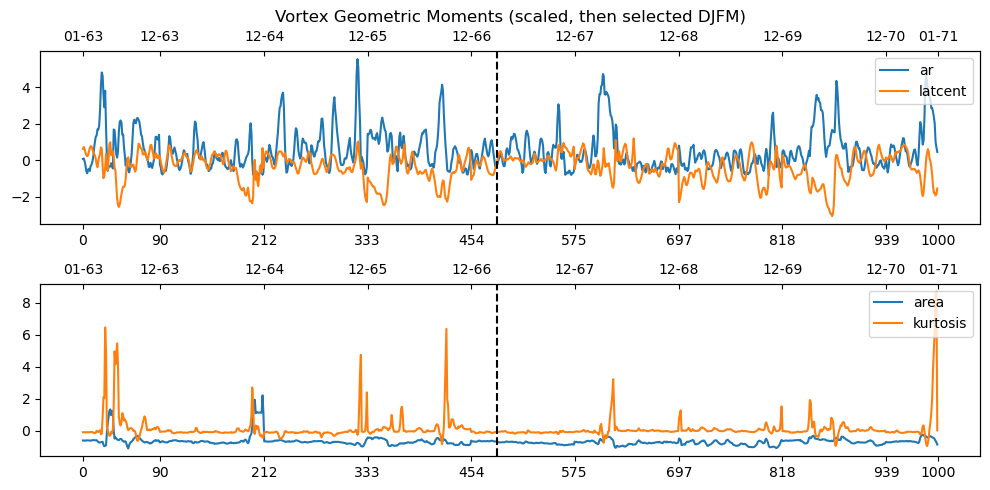

In [4]:
positions = [0]
positions[1: ] = [x for x in range(90, 1000, 121)]
positions[2:] = list(map(lambda x: x+1 , positions[2:]))
positions[6:] = list(map(lambda x: x+1 , positions[6:]))
positions.append(1000)

from arctic.workflows.demo import plot_timeseries_moments
plot_timeseries_moments(era5_hannachi,
                        ['scaled_ar', 'scaled_latcent', 'scaled_area', 'scaled_kurtosis'],
                        ['ar', 'latcent', 'area', 'kurtosis'],
                        title = 'Vortex Geometric Moments (selected to DJFM, then scaled)',
                        time_span=1000,
                        positions=positions,
                        vertical_line=484,
                        savefig='../output/scaled_moments.png')

plot_timeseries_moments(era5_winter,
                        ['scaled_ar', 'scaled_latcent', 'scaled_area', 'scaled_kurtosis'],
                        ['ar', 'latcent', 'area', 'kurtosis'],
                        title = 'Vortex Geometric Moments (scaled, then selected DJFM)',
                        time_span=1000,
                        vertical_line=484,
                        positions=positions)

## Seasonality

### Durbin-Watson Test

The Durbin-Watson test is used to detect the presence of first order autocorrelation in the residuals of a regression model. It assumes that:

- The residuals (errors) are normally distributed with a mean of 0
- The residuals are stationary over time

Commonly, it is interpretated as follows:
- **0 to 1.5**: strong **positive autocorrelation**
- **1.5 to 2.5**: little to **no autocorrelation**
- **2.5 to 4**: strong **negative autocorrelation**

In this analysis, the Durbin-Watson test indicates strong positive autocorrelation in the data, which is consistent with findings by H11.

In [5]:
from statsmodels.stats.stattools import durbin_watson

dw_area = durbin_watson(era5_hannachi['scaled_area'])
print(f"Durbin-Watson statistic on DJFM, then scaled area: {np.round(dw_area, 3)}")
dw_u = durbin_watson(era5_hannachi['scaled_u'])
print(f"Durbin-Watson statistic on DJFM, then scaled wind speed: {np.round(dw_u, 3)}")

Durbin-Watson statistic on DJFM, then scaled area: 0.255
Durbin-Watson statistic on DJFM, then scaled wind speed: 0.036


### Autocorrelation function
To further investigate seasonality, the autocorrelation function (ACF) is used. The ACF measures how well the time series correlates with lagged versions of itself. It is defined at lag $k$ as follows

$$\rho_k = \frac{Cov(x_t, x_{t-k})}{\sigma(x_t) \sigma(x_{t-k})}$$

and computed on unit vector normalised data. Importantly, scaling does not affect the shape of the autocorrelation, as the operation is inherently scale-invariant.

The dashed horizontal lines in the plots represent 5% significance bounds of the autocorrelation. An autocorrelation above or below, indicates a significant correlation at that lag.

⚠ For large lag values, ACF computation can become slow. It is recommended to use lags between 500 and 1500.

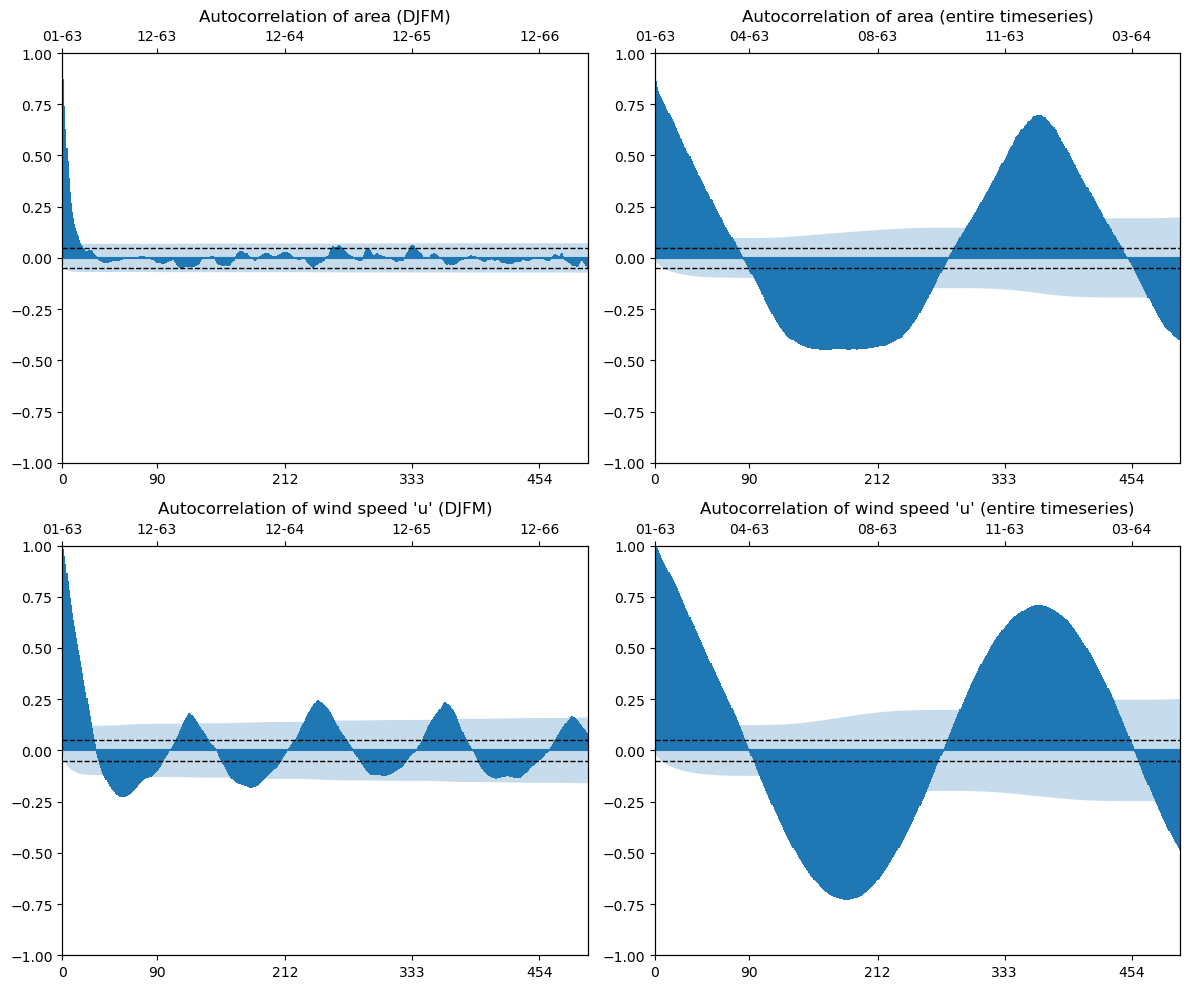

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(2,2, figsize=(12, 10))
ax = ax.flatten()

plot_acf(era5_hannachi['area'], lags=500, ax=ax[0],  marker=None)
plot_acf(era5_all['area'], lags=500, ax=ax[1], marker=None)

plot_acf(era5_winter['u'], lags=500, ax=ax[2], marker=None)
plot_acf(era5_all['u'], lags=500, ax=ax[3], marker = None)

ax[0].set_title('Autocorrelation of area (DJFM)')
ax[1].set_title('Autocorrelation of area (entire timeseries)')
ax[2].set_title("Autocorrelation of wind speed 'u' (DJFM)")
ax[3].set_title("Autocorrelation of wind speed 'u' (entire timeseries)")

for i in range(4):
    # 5% boundaries
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    # limit at lag
    ax[i].set_xlim(0, 500)
    # reset xticks to 120days period
    ax[i].set_xticks(positions[:5])
    ax[i].set_xticklabels([str(x) for x in positions[:5]])

    # set dates as second axis
    ax_top = ax[i].twiny()
    ax_top.set_xlim(ax[i].get_xlim())
    ax_top.set_xticks(positions[:5])
    if i%2 == 0:
        labels_dt = era5_hannachi.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    else:
        labels_dt = era5_all.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)

plt.tight_layout()
plt.savefig('../output/acf.png')
plt.show()

### Single Spectrum Analysis
The singular spectrum analysis (SSA) can be fundamentally described as a singular value decomposition (SVD) on lagged time series data. It transforms a time series into a multivariate time series using delay coordinates with a sliding window. Deciding the correct window length $M$ is crucial for accurate results. Generally, larger $M$ yield more precise reconstruction, and for periodic signals, $M$ should not significantly exceed the period \cite{hannachi_extended_2021}. Then a SVD is performed on the lagged vectors. The signal can be constructed using the obtained eigenvectors (components).

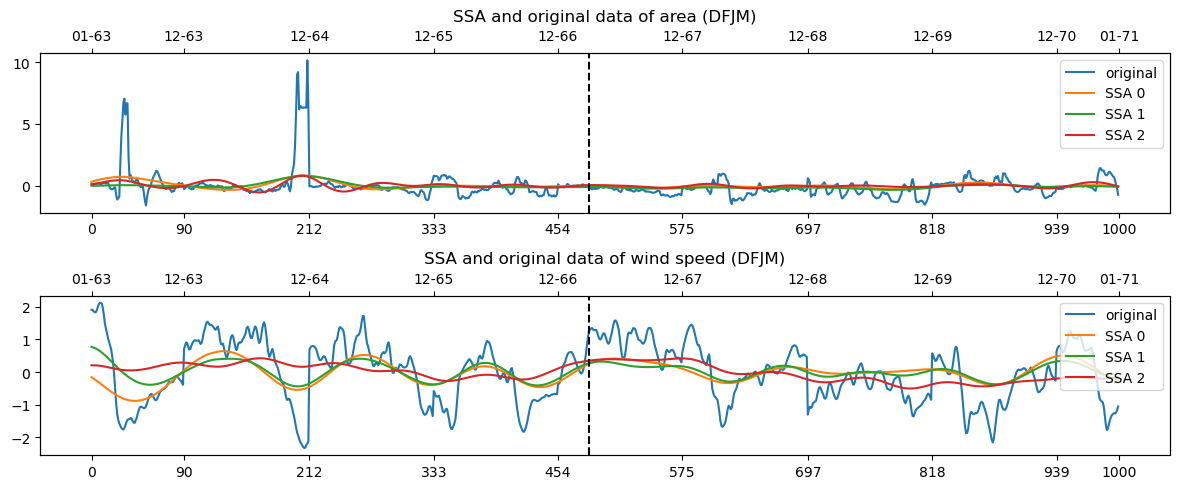

In [7]:
from pyts.decomposition import SingularSpectrumAnalysis
from arctic.workflows.demo import plot_ssa_grid

M = 120
ssa = SingularSpectrumAnalysis(window_size=M)
ssa_area = ssa.fit_transform(era5_hannachi['scaled_area'].values.reshape(1, -1))
ssa_u = ssa.fit_transform(era5_hannachi['scaled_u'].values.reshape(1, -1))

fig, axes = plt.subplots(2, figsize=(12, 5))
axes[0].set_title('SSA and original data of area (DFJM)')
axes[1].set_title('SSA and original data of wind speed (DFJM)')
axes[0].plot(era5_hannachi['scaled_area'][:1000], label='original')
axes[1].plot(era5_hannachi['scaled_u'][:1000], label='original')
for i in range(3):
    axes[0].plot(ssa_area[i, :1000], label=f"SSA {i}")
    axes[1].plot(ssa_u[i, :1000], label=f"SSA {i}")
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
for i in range(2):
    # set dates as second axis
    ax_top = axes[i].twiny()
    ax_top.set_xlim(axes[i].get_xlim())
    ax_top.set_xticks(positions)
    axes[i].set_xticks(positions)
    labels_dt = era5_hannachi.iloc[positions]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
    axes[i].axvline(x=484, color='black', linestyle='--')

plt.tight_layout()
plt.show()

### Extended Empirical Orthogonal Function
The (extended) empirical orthogonal function (EEOF/EOF) works similar to the SSA, but is more suitable for multivariate data. EEOFs aim to identify propagating patterns across multiple spatial locations over time. They are the eigenvectors of the state vector extended by lagged temporal information for each spatial point. As with SSA, signals can be reconstructed and used for filtering of seasonality.

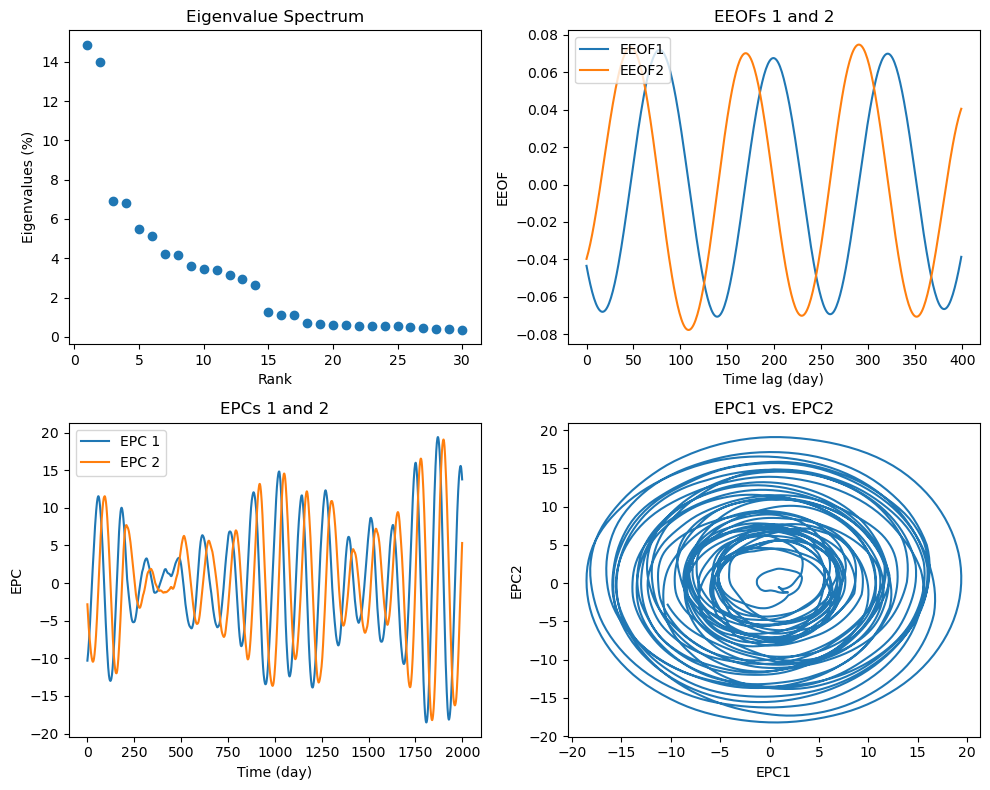

The EEOF evaluation for area based on ERA5 reanalysis data.


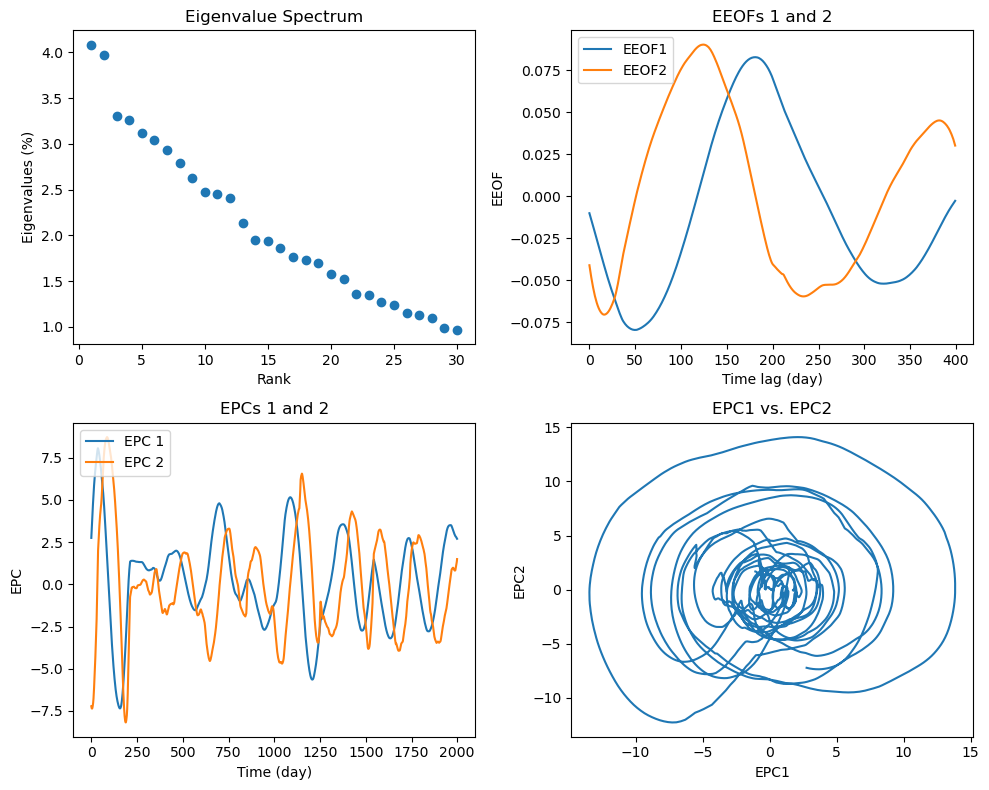

In [8]:
epc_u, eeof_u, expl_var_ratio_u, reconstructed_u, _ = arctic.compute_eeof(era5_hannachi['scaled_u'], M=400, n_components=30)
epc_area, eeof_area, expl_var_ratio_area, reconstructed_area, _ = arctic.compute_eeof(era5_hannachi['scaled_area'], M=400, n_components=30)

from arctic.workflows.demo import plot_eeof
plot_eeof(epc_u, eeof_u, expl_var_ratio_u, "../output/eeof_u.png")
print('The EEOF evaluation for area based on ERA5 reanalysis data.')
plot_eeof(epc_area, eeof_area, expl_var_ratio_area)

### Filtering
To filter the periodic signal it is reconstructed. H11 used the 9 leading EPCs to reconstruct the signal. Below the reconstruction from 4 leading EPCs as well as SSA components are given. Further the signal is reconstructed from 2, 4 and 30 components for comparison.

It can be easily seen that using to many components completely reconstructs the signal and after filtering only noise would remain. We continue with the selection of the 4 leading components as done in H11.

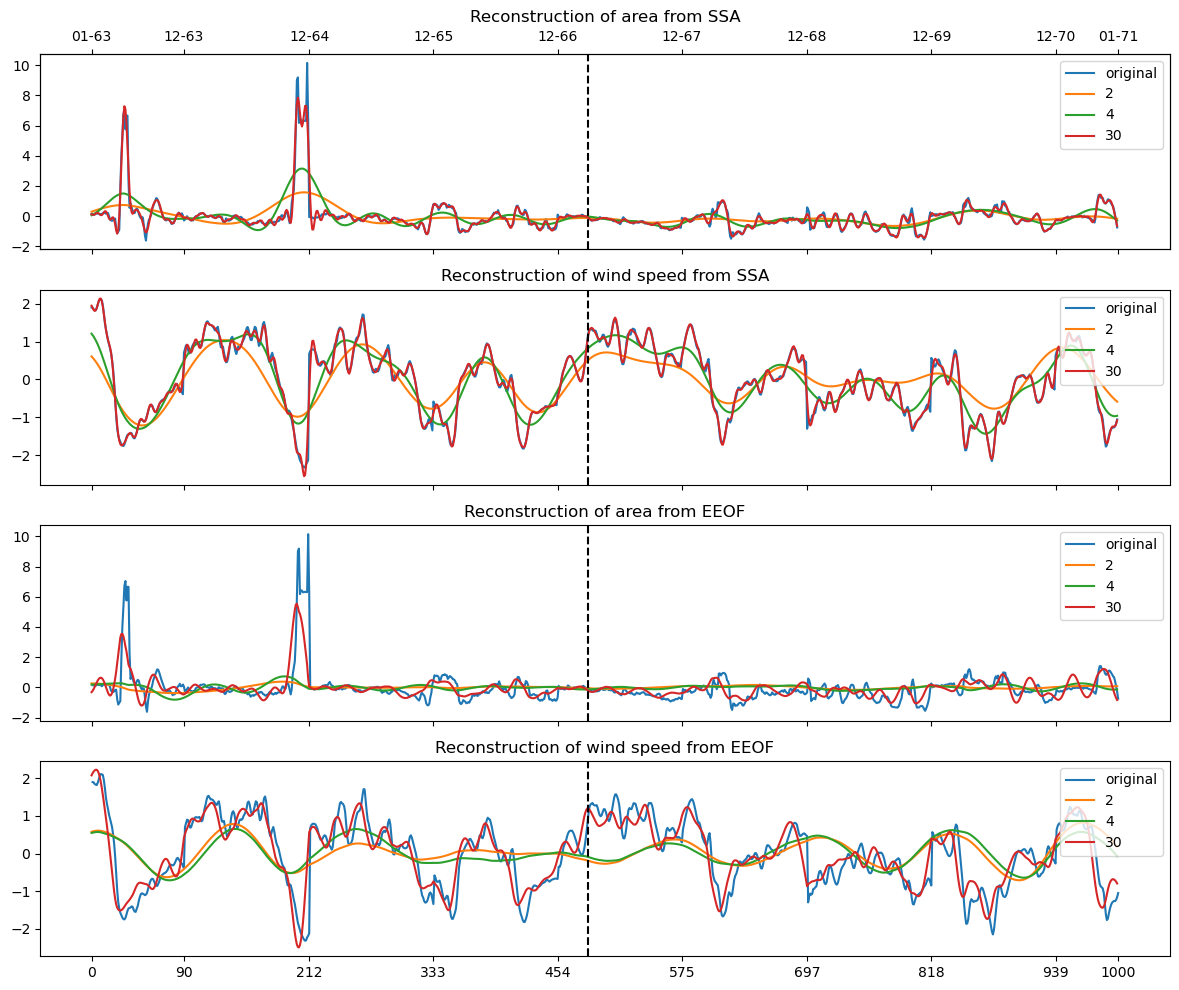

In [9]:
fig, ax = plt.subplots(4, figsize=(12, 10), sharex='all')

ax[0].set_title('Reconstruction of area from SSA')
ax[1].set_title("Reconstruction of wind speed from SSA")
ax[2].set_title('Reconstruction of area from EEOF')
ax[3].set_title("Reconstruction of wind speed from EEOF")

ax[0].plot(era5_hannachi['scaled_area'][:1000], label='original')
ax[1].plot(era5_hannachi['scaled_u'][:1000], label='original')
ax[2].plot(np.arange(1, 1001), era5_hannachi['scaled_area'][:1000], label='original')
ax[3].plot(np.arange(1, 1001), era5_hannachi['scaled_u'][:1000], label='original')
for i in [2, 4, 30]:
    ssa_reconstructed_area = ssa_area[:i].sum(axis = 0)
    ssa_reconstructed_u = ssa_u[:i].sum(axis=0)
    _, _, _, eeof_reconstructed_area, _ = arctic.compute_eeof(era5_hannachi['scaled_area'], M=400, n_components=i)
    _, _, _, eeof_reconstructed_u, _ = arctic.compute_eeof(era5_hannachi['scaled_u'], M=400, n_components=i)
    ax[0].plot(ssa_reconstructed_area[:1000], label=f"{i}")
    ax[1].plot(ssa_reconstructed_u[:1000], label=f"{i}")
    ax[2].plot(eeof_reconstructed_area[399:1399, 0], label=f"{i}")
    ax[3].plot(eeof_reconstructed_u[399:1399, 0], label=f"{i}")

for i in range(4):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')
# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions)
ax[0].set_xticks(positions)
labels_dt = era5_hannachi.iloc[positions]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.show()

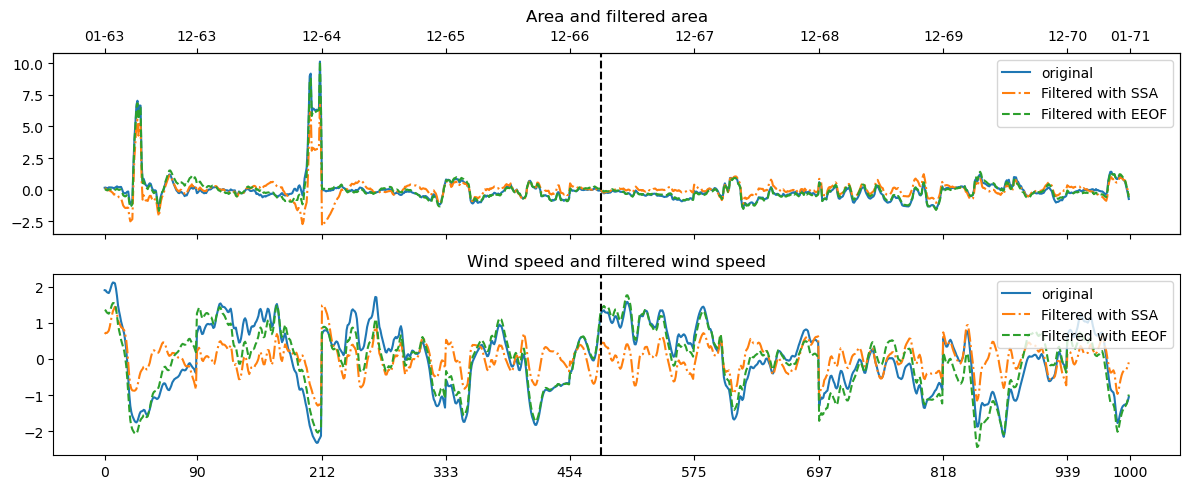

In [10]:
# compute eeof with respective number of components
_, _, _, eeof_reconstructed_area, _ = arctic.compute_eeof(era5_hannachi['scaled_area'], M=400, n_components=4)
_, _, _, eeof_reconstructed_u, _ = arctic.compute_eeof(era5_hannachi['scaled_u'], M=400, n_components=4)

# reduce data to match the time conditions in H11 (1958 to 2002)
era5_hannachi = era5_hannachi[era5_hannachi['string'] < '01-01-2003']

era5_hannachi['ssa_filtered_area'] = era5_hannachi['scaled_area'] - ssa_area[:4, :era5_hannachi.shape[0]].sum(axis = 0).T
era5_hannachi['ssa_filtered_u'] = era5_hannachi['scaled_u'] - ssa_u[:4, :era5_hannachi.shape[0]].sum(axis=0).T
era5_hannachi['eeof_filtered_area'] = era5_hannachi['scaled_area'] - eeof_reconstructed_area[399:, 0].T
era5_hannachi['eeof_filtered_u'] = era5_hannachi['scaled_u'] - eeof_reconstructed_u[399:, 0].T

fig, ax = plt.subplots(2, figsize=(12, 5), sharex='all')
ax[0].set_title('Area and filtered area')
ax[0].plot(era5_hannachi['scaled_area'][:1000], label='original')
ax[0].plot(era5_hannachi['ssa_filtered_area'][:1000], '-.', label='Filtered with SSA')
ax[0].plot(era5_hannachi['eeof_filtered_area'][:1000], '--', label='Filtered with EEOF')
ax[1].set_title('Wind speed and filtered wind speed')
ax[1].plot(era5_hannachi['scaled_u'][:1000], label='original')
ax[1].plot(era5_hannachi['ssa_filtered_u'][:1000], '-.', label='Filtered with SSA')
ax[1].plot(era5_hannachi['eeof_filtered_u'][:1000], '--', label='Filtered with EEOF')

for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')
# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions)
ax[0].set_xticks(positions)
labels_dt = era5_hannachi.iloc[positions]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.savefig("../output/ssa_eeof_era5.png")
plt.show()

## Gap statistic
The performance of clustering algorithm depends severely on the right number of clusters as input. The determination of the right number of cluster $k$ is subject to a lot of research, as fitting models is computationally expensive and more elegant ways than simply testing different $k$ are required. Further unsupervised clustering has no notion of wrong or right, but requires different measures to evaluate a models quality. Most methods define a measure of similarity, which should be maximized in clusters and minimized between clusters. Consequently, dissimilarity is defined vice versa. Then the similarity or dissimilarity is compared for different values of $k$.

The gap statistic introduced by Tibshirani et al. (2001) bases on the idea to compare the within cluster dispersion of the actual data to a null reference. The null reference is usually generated by a homogeneous Poisson point process (HPPP).

To compute the within cluster dispersion, the pairwise squared distances between all data points in a cluster $C_m, m=1, ..., k$ are computed by

$$D_m = \sum_{i,j \in C_m} \|x_i- x_j\|^2 = 2n_m \sum_{i=1}^{n_m} \|x_i- \mu_m\|^2$$

with $|C_m| = n_m$ being the size of the $m$th cluster.

Some implementations use the distance $\|x_i - c_m\|$, i.e. the distance of a data point $x_i$ to its corresponding cluster center $c_m=\mu_m$. This is only applicable in clustering algorithms that have some notion of centers such as k-means. For clustering methods without such centers such as hierarchical clustering, the gap statistic is more precise using the above notation instead of calculating centers manually.

In the next step, $D_m$ is averaged to obtain
$$W_k = \sum_{m=1}^{k} \frac{D_m}{2n_m}$$
The sum of squared distances to the center of a cluster is the same as $W_k$ as long there are no sample weights.

Finally, the gap statistic for each $k$ is computed by the difference between the *within dispersion index* of the data, $log(W_k)$,  and that expected from the generated reference $log(W_k^*)$.
$$G(k) = E[log(W_k^*)] - log(W_k)$$


Here, $E(\cdot)$ is the expectation as usually defined. A Monte Carlo simulation is used to generate $N$ samples of $log(W_k^*)$, where each $W_k^*$ is based on the same number of points as the original data. Additionally, the standard deviation $s_k^*$ is computed and used to account for the simulation error in $E[log(W_k^*)]$ with the inflated standard deviation $s_k = s_k^*\sqrt{1+\frac{1}{N}}$. Finally, the optimal $k_{opt}$ is determined by the smallest $k$ such that

$$
	G(k) \geq G(k+1) - s_{k+1}
$$

Tibshirani et al. conducted a comparative analysis demonstrating that the gap statistic is a robust method for estimating the number of clusters. Their findings indicate that, for elongated clusters, the gap statistic yields better results with a null reference aligned to the data's principle components. In contrast, using a simple uniform distribution leads to inferior results. Overall, the underlying distribution of data does not influence the results of the gap statistic, making it more robust than other methods.

The performance of the gap statistic deteriorates in high-dimensional settings due to computational costs. It is also prone to underestimation the optimal $k$ in settings with many clusters. The underestimation vanishes with increasing dimensionality.

H11 focused on the Gap statistic which is also implemented below. Additionally, elbow and silhouette methods are considered and compared to the results of the gap statistic.

## Hierarchical Clustering
Hierarchical clustering is a family of clustering methods that focuses on building nested clusters. This is achieved by merging or splitting them successively. The hierarchy can be represented in a so-called dendrogram, i.e. a tree, where the root contains all samples and each leaf represents a samples. Leaves next to each other correspond to similar samples. H11 does not further specify what hierarchical clustering algorithm is used. Here, agglomorative clustering was used as an adaption.

Agglomerative clustering uses a bottom up approach, i.e. each sample represent its own cluster and is successively merged with the most similar cluster. The linkage describes the merging strategy and computation of distance between clusters. The default is $complete$ as determined in H11 to avoid spheroidal or chaining clusters and distance means the Euclidean distance. Below an overview of some linkage methods is given.

|               | between points in Cluster | to different clusters                      |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

The code cells below might take a few minutes to compute due to the computationally expensive operations of training a model and computing the corresponding metric for evaluation.


In [11]:
k_max = 10
gap_ar_latcent = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_filteredssa = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_u = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max, n_replicates=15)

In [12]:
elbow_ar_latcent = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max)
elbow_ar_latcent_area = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
elbow_ar_latcent_filteredssa = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max)
elbow_ar_latcent_u = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

In [13]:
silhouette_ar_latcent = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max)
silhouette_ar_latcent_area = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
silhouette_ar_latcent_filteredssa = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max)
silhouette_ar_latcent_u = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

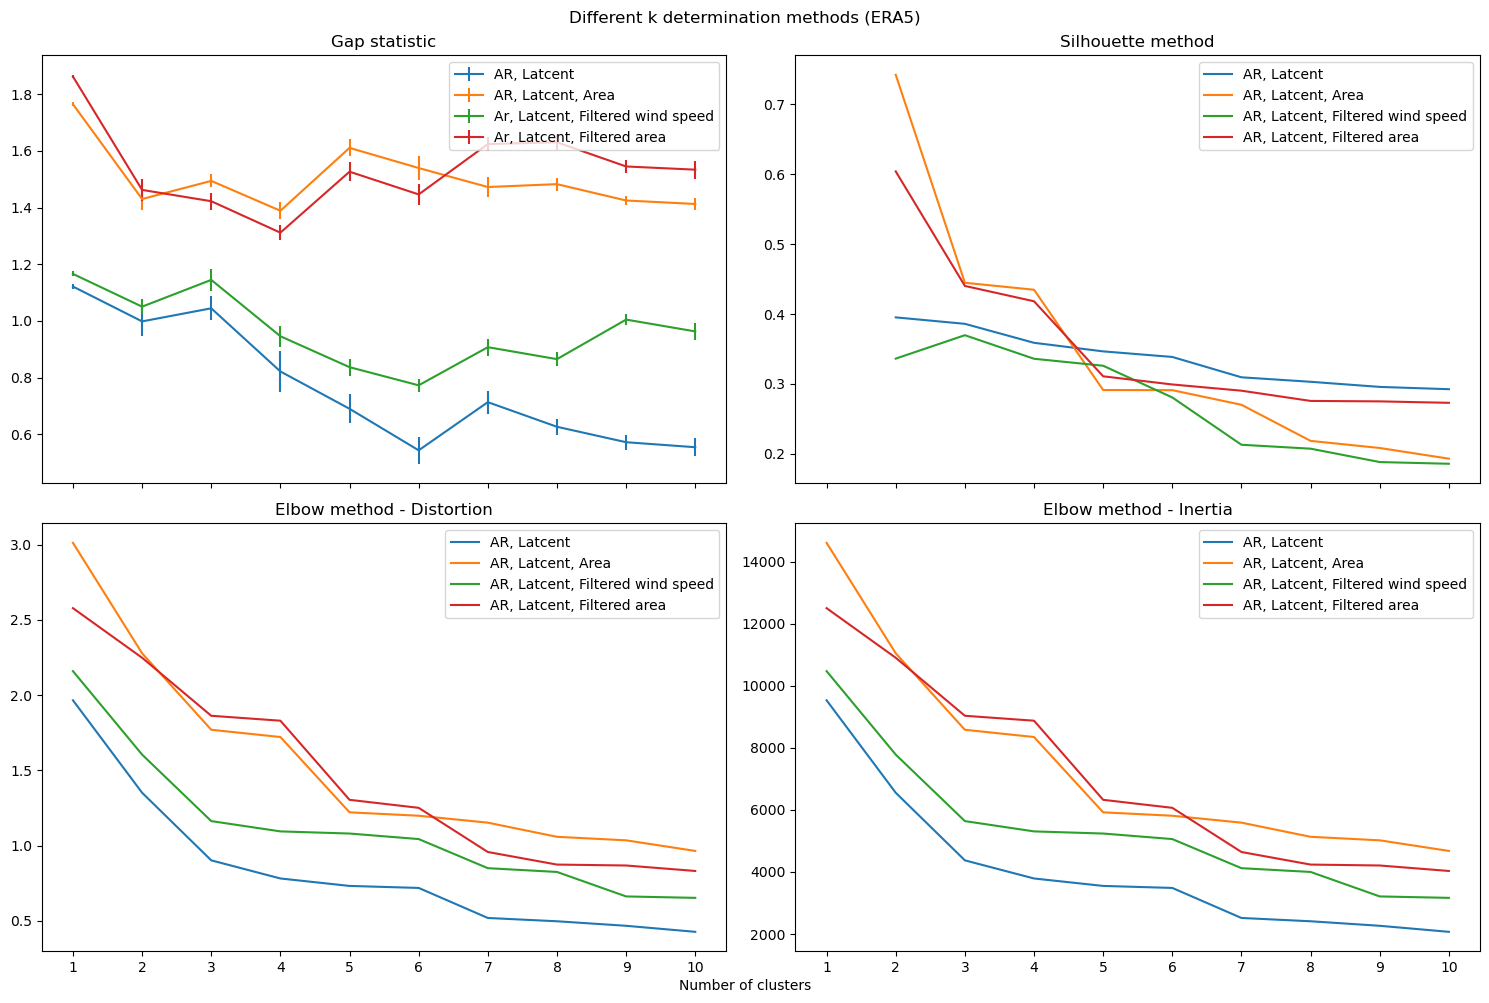

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15, 10), sharex='all')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent[:, 0], yerr=gap_ar_latcent[:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_area[:, 0], yerr=gap_ar_latcent_area[:, 1], label='AR, Latcent, Area')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_u[:, 0], yerr=gap_ar_latcent_u[:, 1], label='Ar, Latcent, Filtered wind speed')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_filteredssa[:, 0], yerr=gap_ar_latcent_filteredssa[:, 1], label='Ar, Latcent, Filtered area')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend(loc='upper right')

ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent[0], label='AR, Latcent')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[0], label='AR, Latcent, Area')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[0], label='AR, Latcent, Filtered wind speed')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_filteredssa[0], label='AR, Latcent, Filtered area')
ax[1][0].set_title('Elbow method - Distortion')
ax[1][0].legend(loc='upper right')

ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent[1], label='AR, Latcent')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[1], label='AR, Latcent, Area')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[1], label='AR, Latcent, Filtered wind speed')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_filteredssa[1], label='AR, Latcent, Filtered area')
ax[1][1].set_title('Elbow method - Inertia')
ax[1][1].legend(loc='upper right')

ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_u, label='AR, Latcent, Filtered wind speed')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_filteredssa, label='AR, Latcent, Filtered area')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend(loc='upper right')

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(1, k_max+1))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
plt.savefig('../output/Kopt_era5.png')
plt.show()

In [15]:
print("Optimal number of clusters by each method: ")
p_1, p_2, p_3, p_4 = 1,1,1,1
for k in range(1, 10):
    if p_1 and (gap_ar_latcent[k][0] >= gap_ar_latcent[k+1][0] - gap_ar_latcent[k+1][1]):
        print('Gap statistic (AR, Latcent): ', k+1) # index starts at 0, k starts at 1
        p_1=0
    if p_2 and (gap_ar_latcent_area[k][0] >= gap_ar_latcent_area[k+1][0] - gap_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, Latcent, Area): ", k+1)
        p_2 = 0
    if p_4 and (gap_ar_latcent_filteredssa[k][0] >= gap_ar_latcent_filteredssa[k+1][0] - gap_ar_latcent_filteredssa[k+1][1]):
        print("Gap statistic (AR, Latcent, SSA filtered Area): ", k+1)
        p_4 = 0
    if p_3 and (gap_ar_latcent_u[k][0] >= gap_ar_latcent_u[k+1][0] - gap_ar_latcent_u[k+1][1]):
        print("Gap statistic (AR, Latcent, filtered wind speed): ", k+1)
        p_3=0

print("Silhouette method (AR, Latcent): ", pd.DataFrame(silhouette_ar_latcent).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Area): ", pd.DataFrame(silhouette_ar_latcent_area).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered Area): ", pd.DataFrame(silhouette_ar_latcent_filteredssa).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered wind speed): ", pd.DataFrame(silhouette_ar_latcent_u).idxmax()[0]+2)

Optimal number of clusters by each method: 
Gap statistic (AR, Latcent, SSA filtered Area):  2
Gap statistic (AR, Latcent):  3
Gap statistic (AR, Latcent, Area):  3
Gap statistic (AR, Latcent, filtered wind speed):  3
Silhouette method (AR, Latcent):  2
Silhouette method (AR, latcent, Area):  2
Silhouette method (AR, latcent, filtered Area):  2
Silhouette method (AR, latcent, filtered wind speed):  3


### Optimal number of clusters
The gap statistic suggest that the data lacks inherent clustering structure, consistently favouring $k=1$. The silhouette method partially supports that.

However, when assuming that at least some structure exists and evaluating $k > 1$, all methods indicate $k_{opt} = 3$ when clustering based o ar and latcent, or ar, latcent and the filtered wind speed. The wind speed acts as a proxy for the behaviour of the area as used in H11.

In contrast, the introduction of the area computed from $Z10$ leads to ambiguity. The gap statistic and silhouette method indicate no structure in the data. Though the gap statistic has local maxima at $k=3$ and $k=5$. And another at $k=7$ when the area is filtered. It is a known disadvantage of the gap statistic, that it will select the first local maxima as optimal $k$, even though another $k$ might be more suitable. The silhouette method has sharp breaks at $k=3$ and $k=5$ indicating possible values. A similar behaviour can be observed with the elbow method. Tough even for $k=7$ could be argued for with the elbow method.

Tabular summary of $k_o{opt}$ for each method:

| Used features              | Gap statistic | Silhouette  | Elbow (Distortion) | Elbow (Inertia) |
|----------------------------|---------------|-------------|--------------------|-----------------|
| AR, latcent                | 1 or 3        | 2           | 3                  | 3               |
| AR, latcent, wind speed    | 1 or 3        | 3           | 3                  | 3               |
| AR, latcent, area          | 1 or 3 or 5   | 2 or 3 or 5 | 3 or 5             | 3 or 5          |
| AR, latcent, filtered area | 1 or 5 or 7   | 3           | 3 or 5             | 3 or 5          |


#### Possible reasons for differences to H11
- different data: H11 used ERA-40 data, here ERA5 is used and hierarchical clustering depends severly on the precise data distribution
- different aggregation: Only aggregated ERA5 data were processed. As mentioned previously, the method to compute the area are fundamentally different.
- different scaling: The used scaling could be different, unlikely regarding the structure in plots of the scaled data. But the absolute magnitude may differ due to variations in the data distribution.
- no autocorrelation in area: the filtering could introduce bias into area
- wind speed as a proxy for the area at 850K potential vorticity

For the remainder of the analysis $k_{opt} = 3$ is adopted, based on convergence of the elbow method, gap statistic and silhouette method for clustering based on ar, latcent and wind speed and as determined by H11.

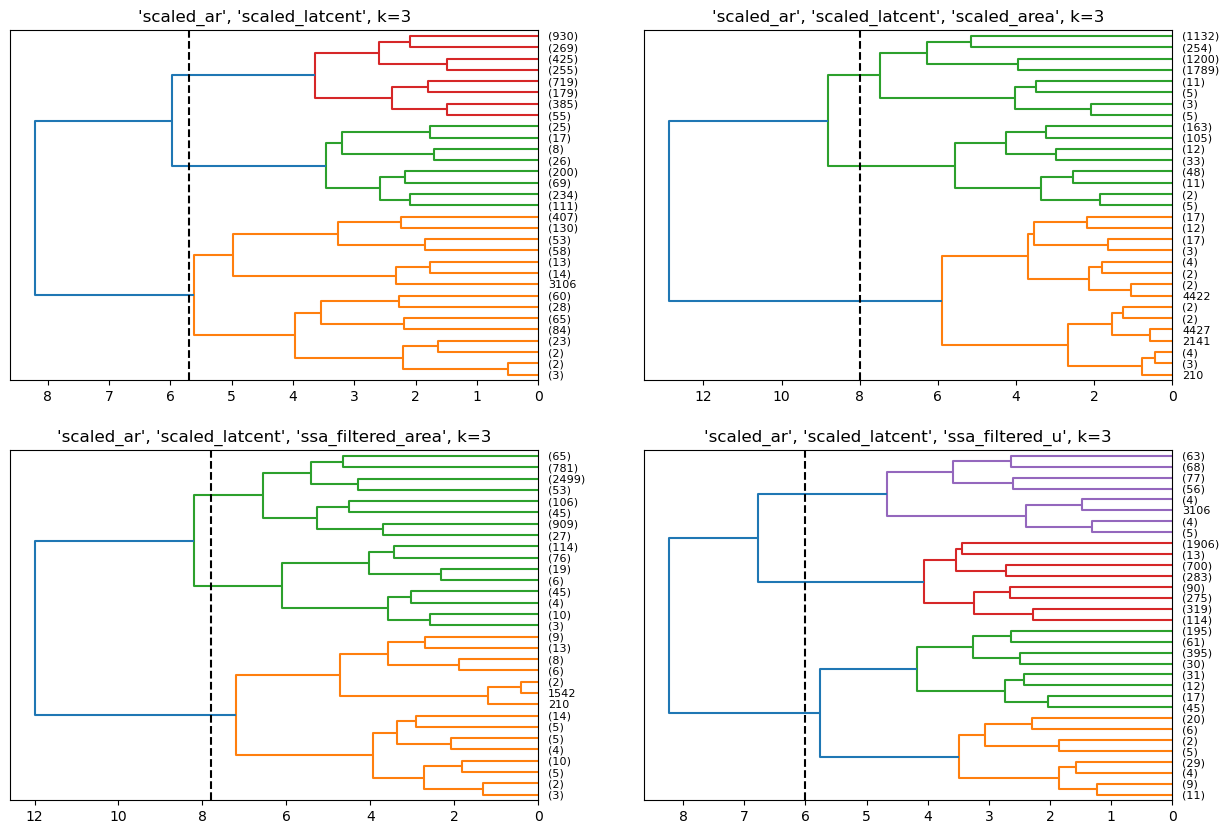

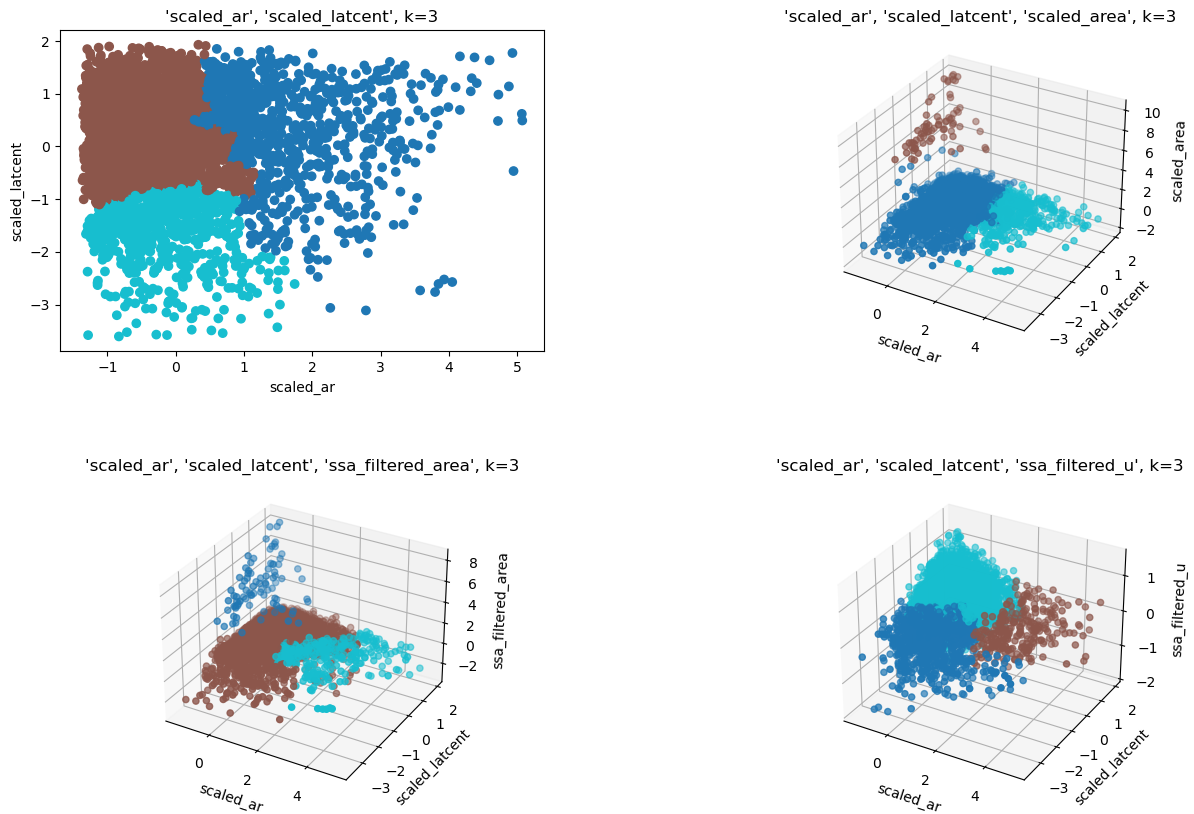

In [16]:
from sklearn import clone
from sklearn.cluster import AgglomerativeClustering

features_kopt = [{'features' : ['scaled_ar', 'scaled_latcent'], 'k_opt' : 3, 'line':5.7},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'scaled_area'], 'k_opt' : 3, 'line':8},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'ssa_filtered_area'], 'k_opt' : 3, 'line':7.8},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'ssa_filtered_u'], 'k_opt' : 3, 'line':6}]


Y = []
base_model = AgglomerativeClustering(linkage='complete', compute_distances=True)

fig = plt.figure(figsize=(15,10))
for idx, feat_k in enumerate(features_kopt):
    model = clone(base_model)
    model.set_params(n_clusters = feat_k['k_opt'])
    model.fit(era5_hannachi[feat_k['features']])
    ax = fig.add_subplot(2,2,idx+1)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
    arctic.plot_dendrogram(model, truncate_mode='level', p=4, direction='LR', savefig=f"../output/hc_{'_'.join(feat_k['features'])}_{feat_k['k_opt']}.png")
    ax.axvline(feat_k['line'], ls='--', color='black')
    y_pred = model.labels_.astype(int)
    Y.append(y_pred)
plt.show()

fig = plt.figure(figsize=(15,10))
for idx, feat_k in enumerate(features_kopt):
    if len(feat_k['features']) == 3:
        ax = fig.add_subplot(2,2,idx+1, projection='3d')
        ax.scatter(era5_hannachi[feat_k['features']].iloc[:, 0],
                   era5_hannachi[feat_k['features']].iloc[:, 1],
                   era5_hannachi[feat_k['features']].iloc[:, 2],
                   c=Y[idx], cmap='tab10')
        ax.set_facecolor((0, 0, 0, 0))
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
        ax.set_zlabel(feat_k['features'][2])
    else:
        ax = fig.add_subplot(2,2, idx+1)
        ax.scatter(era5_hannachi[feat_k['features']].iloc[:, 0],
                   era5_hannachi[feat_k['features']].iloc[:, 1],
                   c=Y[idx], cmap='tab10')
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
plt.savefig('../output/scatter_clusters.png')
plt.show()

# Results
Below the relative and absolute distribution of physical measurements for each cluster is visualized. The goal is to identify and assign clear characteristics for each cluster. It is expected to clearly recognize a split cluster (S) that corresponds to the threshold based assignment of split. Additionally, a displaced cluster (D) is expected that should be characterized by significantly different distribution of latcent. The later may be hard to distinguish as split events are usually accompanied by displacement.

## Statistical Profiles of Clusters
### Aspect ratio and Latcent
The majority of samples falls into Class **1**, which does not show any remarkable characteristics. Class **0** exhibits a significantly larger ar than the other two clusters, which does have a minimum of $ar_{scaled}=0.271$ (resp. $ar=1.735$). Class **2** displays a significantly smaller latcent, not exceeding the average latcent at 0. Consequently, classes are assigned as follows:

**0** &rarr; S (Split)<br>
**1** &rarr; U (Undisturbed/normal state)<br>
**2** &rarr; D (Displaced)

Averages per class and features:
              scaled_ar  scaled_latcent
y_ar_latcent                           
D             -0.139642       -1.635846
S              1.560738        0.333360
U             -0.436129        0.299781


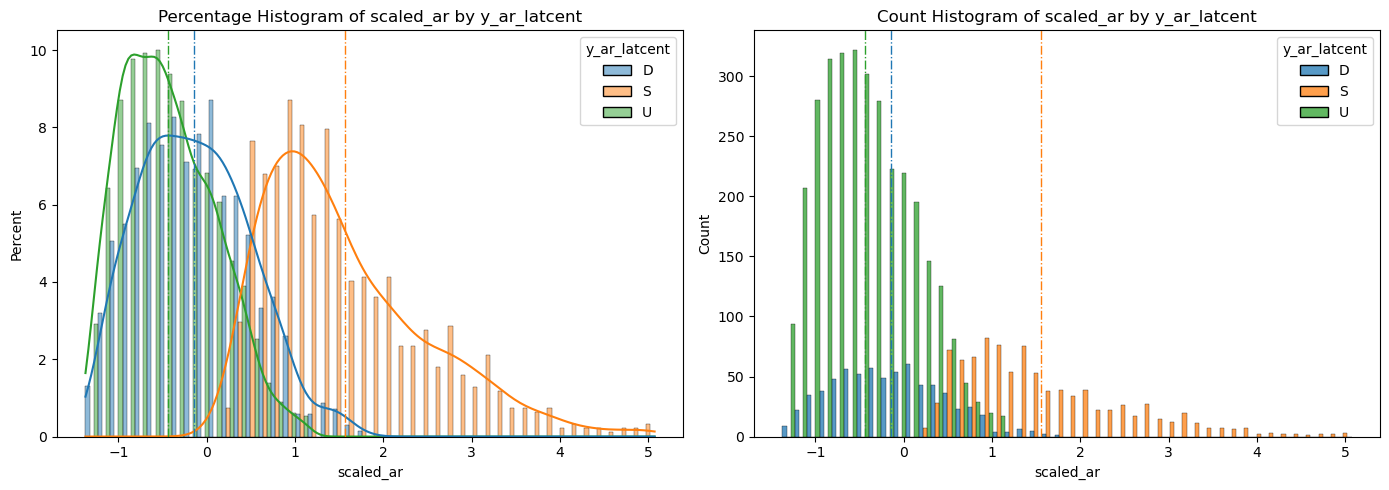

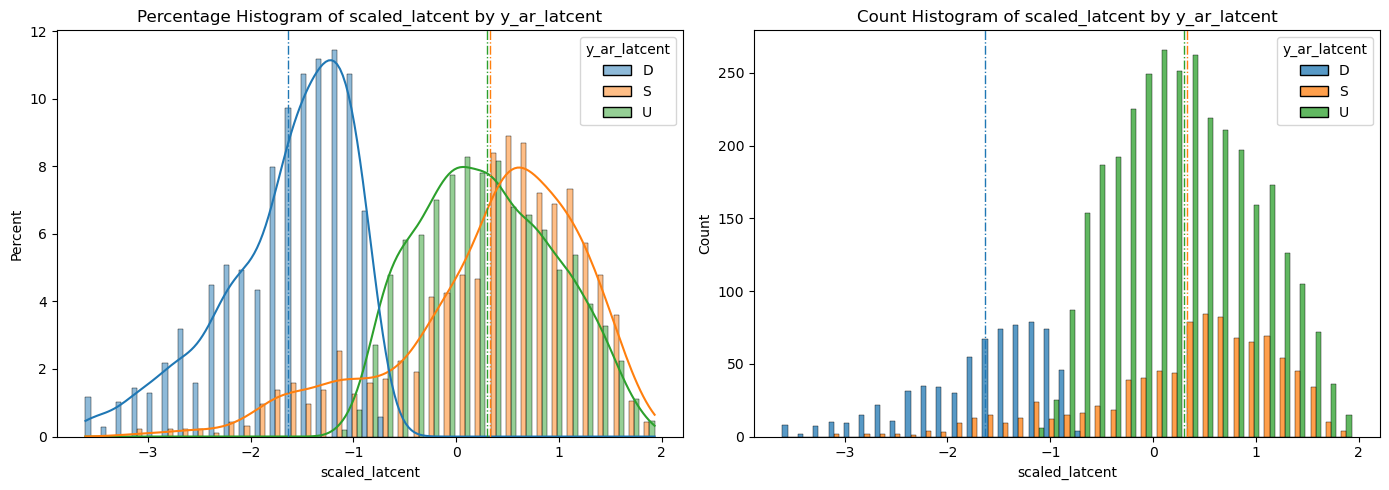

In [17]:
from arctic.workflows.demo import plot_hist_per_class

y_names = ['y_ar_latcent', 'y_ar_latcent_scArea', 'y_ar_latcent_filteredArea', 'y_ar_latcent_u']
era5_hannachi[y_names] = pd.DataFrame(Y).T

era5_hannachi['y_ar_latcent'] = era5_hannachi['y_ar_latcent'].replace({0: 'S', 1:'U', 2:'D'})
print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent', 'scaled_ar', 'scaled_latcent']].groupby(['y_ar_latcent']).mean())

plot_hist_per_class(era5_hannachi, # data
                    features_kopt[0], # information about used feature and k_opt
                    'y_ar_latcent') # column name with y values


### Aspect ratio, latcent and wind speed
When adding the wind speed as a proxy for the area in H11, the distinction between the above classes becomes even clearer. The majority of samples falls into Class **2**, which is characterised by relatively average values for latcent and ar. Interestingly, it has higher values for the filtered wind speed than the other two classes. Class **1** exhibits a significantly larger ar and class **0** displays a significantly smaller latcent. Assigning the S, D, and U respectively, it matches the observation that **1** and **0** have similar distributions for the wind speed, but generally weaker winds than **2**. Split and disturbed events usually result in weakened westerlies or even their reversal. Consequently, classes are assigned as follows:

**0** &rarr; D (Displaced)<br>
**1** &rarr; S (Split)<br>
**2** &rarr; U (Undisturbed/normal state)

Averages per class and features:
                scaled_ar  scaled_latcent  ssa_filtered_u
y_ar_latcent_u                                           
D                0.182125       -1.500504       -0.381814
S                2.601232        0.257020       -0.292167
U               -0.245826        0.374867        0.117274


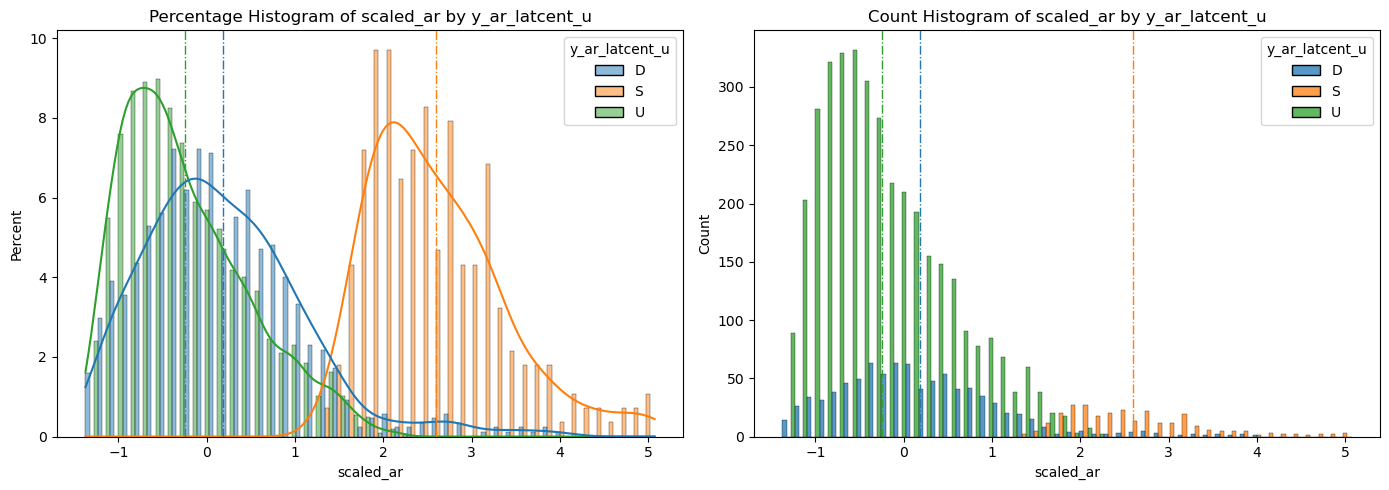

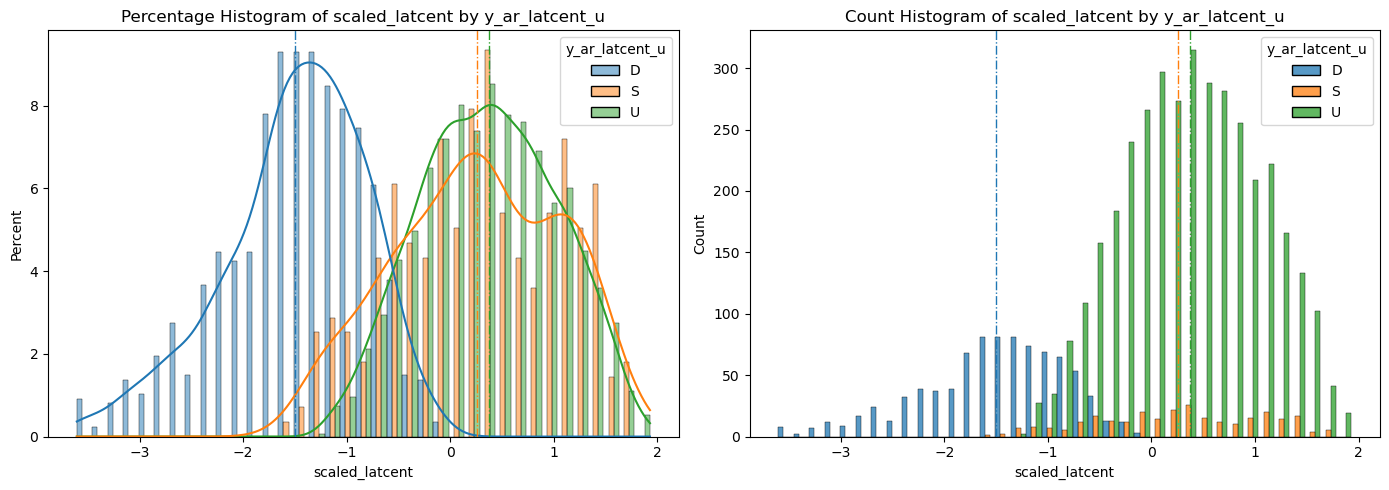

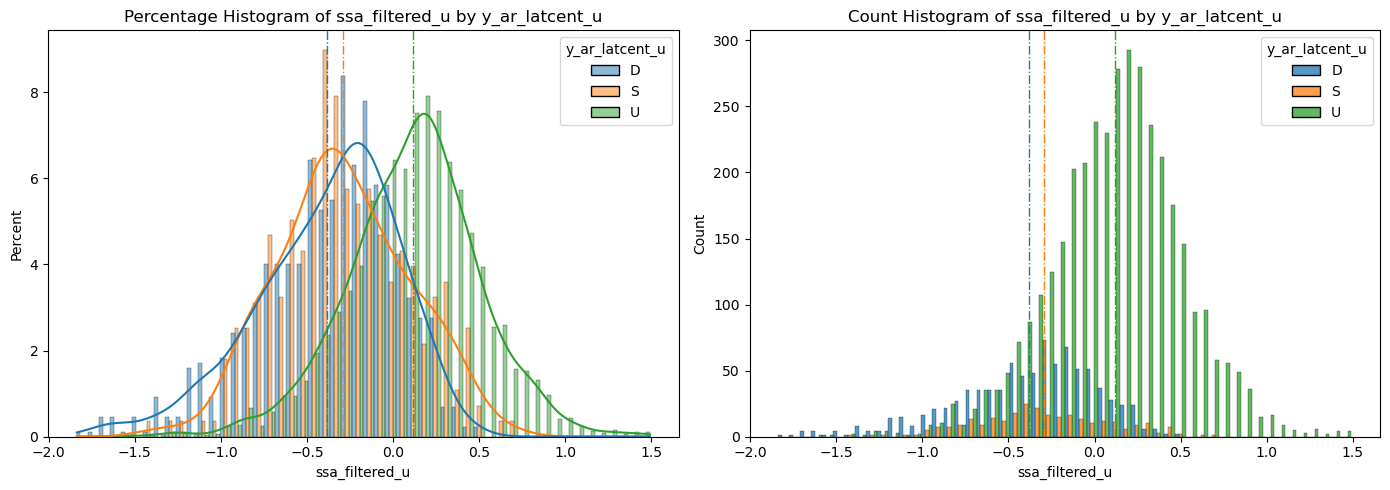

In [18]:
era5_hannachi['y_ar_latcent_u'] = era5_hannachi['y_ar_latcent_u'].replace({0:'D', 1:'S', 2:'U'})
print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent_u', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_u']].groupby(['y_ar_latcent_u']).mean())
plot_hist_per_class(era5_hannachi, # data
                    features_kopt[3], # information about used feature and k_opt
                    'y_ar_latcent_u') # column name with y values


### Aspect ratio, latcent and vortex area
Adding the area computed with at 10hPa geopotential height, added some ambuguity to the interpretation as split, displaced and undisturbed. As bevor a class with a higher values in ar could be characterized. For both, the filter and unfiltered area, class **2**. The centroid latitude distribution occurs to be roughly the same for all classes in both scenarios. The distinction between class **0** and **1** occurs with the area, where one class is easily described by a few samples with very large area values. Hence, a new class label *large* is introduced to characterize this class. Labels could be assigned as follows:

For the unfiltered area:<br>
**0** &rarr; U (Undisturbed/normal state)<br>
**1** &rarr; L (Large)<br>
**2** &rarr; S (Split)

For the filtered area:<br>
**0** &rarr; L (Large)<br>
**1** &rarr; U (Undisturbed/normal state)<br>
**2** &rarr; S (Split)

Averages per class and features:
                     scaled_ar  scaled_latcent  scaled_area
y_ar_latcent_scArea                                        
L                    -0.943072        0.342066     6.904661
S                     2.431698        0.276978     0.117099
U                    -0.200344        0.004641    -0.127405


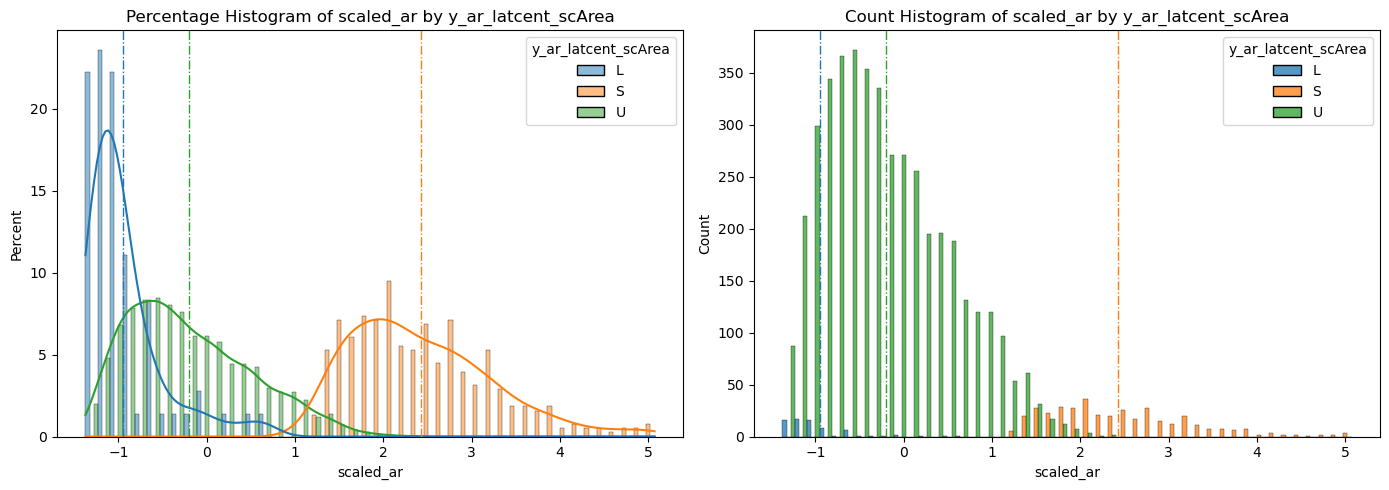

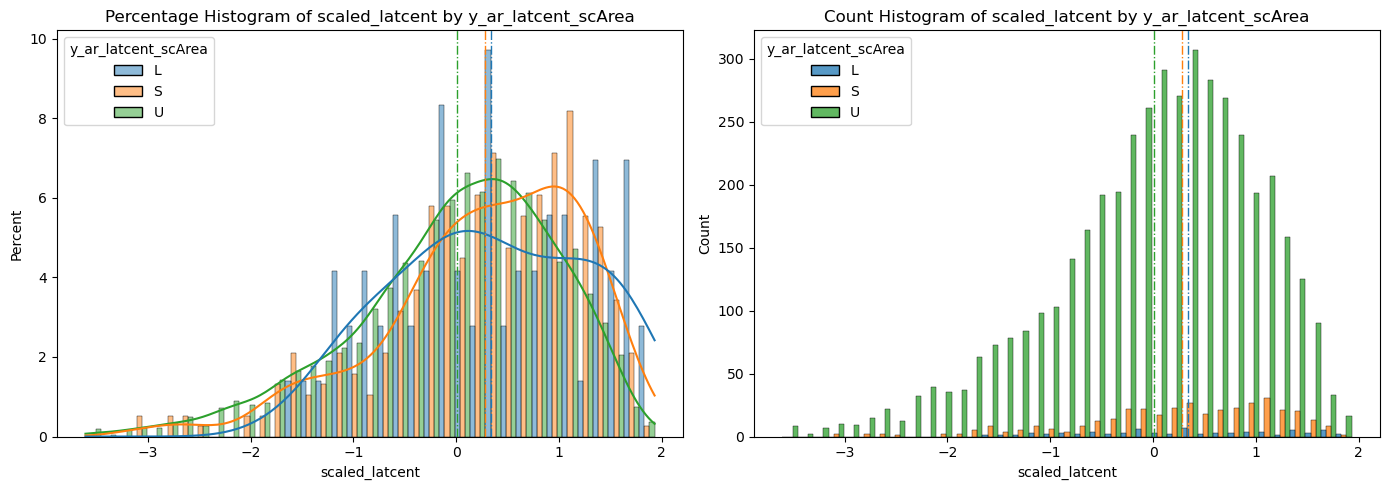

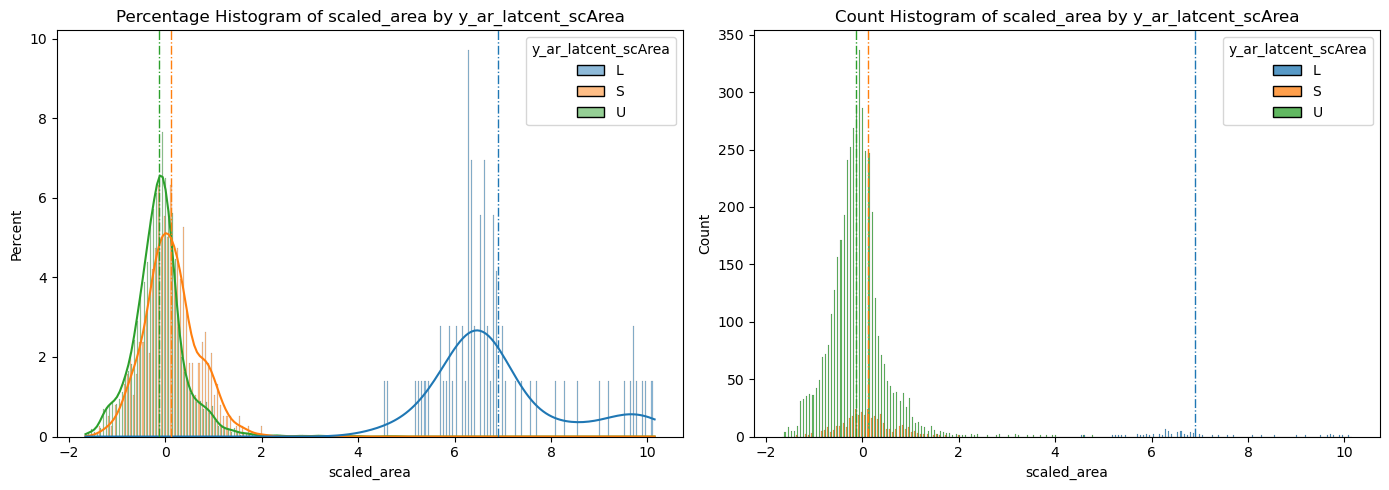

Averages per class and features:
                           scaled_ar  scaled_latcent  ssa_filtered_area
y_ar_latcent_filteredArea                                              
L                          -0.844085        0.270181           4.131017
S                           2.488939       -0.261740           0.276208
U                          -0.143313        0.044313          -0.099780


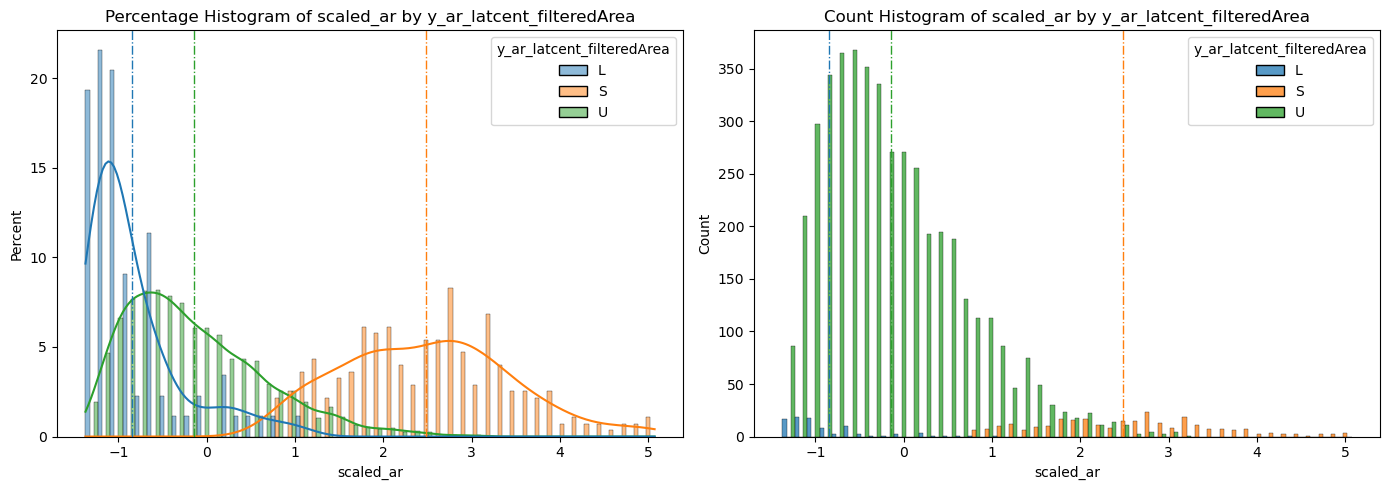

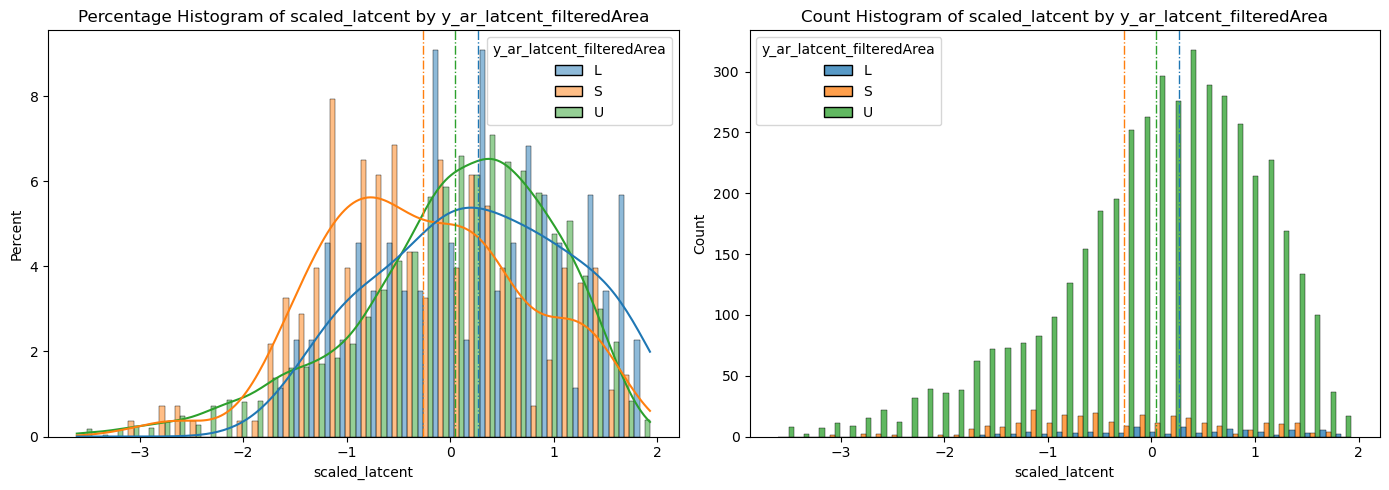

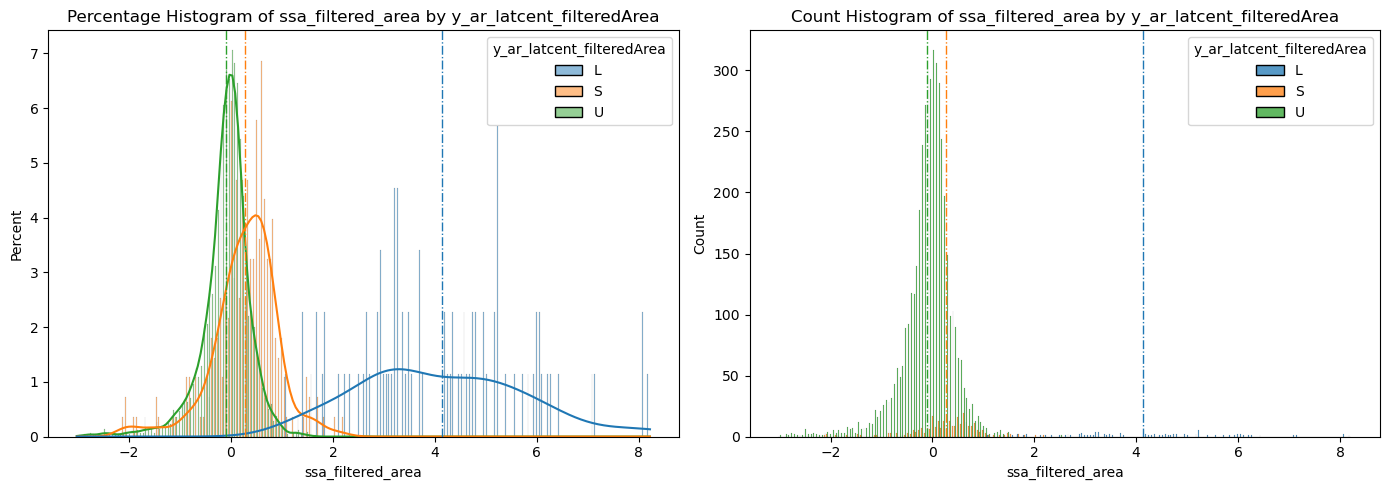

In [19]:
era5_hannachi['y_ar_latcent_scArea'] = era5_hannachi['y_ar_latcent_scArea'].replace({0: 'U', 1:'L', 2:'S'})
era5_hannachi['y_ar_latcent_filteredArea'] = era5_hannachi['y_ar_latcent_filteredArea'].replace({0: 'L', 1:'U', 2:'S'})

print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent_scArea', 'scaled_ar', 'scaled_latcent', 'scaled_area']].groupby(['y_ar_latcent_scArea']).mean())

plot_hist_per_class(era5_hannachi, # data
                    features_kopt[1], # information about used feature and k_opt
                    'y_ar_latcent_scArea') # column name with y values

print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent_filteredArea', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_area']].groupby(['y_ar_latcent_filteredArea']).mean())

plot_hist_per_class(era5_hannachi, # data
                    features_kopt[2], # information about used feature and k_opt
                    'y_ar_latcent_filteredArea') # column name with y values

## Physical interpretation and Literature Comparison

The following table illustrates the distribution of classes in H11:

<table>
  <tr>
    <th></th>
    <th colspan="4">AR, Latcent and filtered Area</th>
  </tr>
  <tr>
    <th>AR, Latcent</th>
    <th>D (0) </th>
    <th>U (2) </th>
    <th>S (1) </th>
    <th>Total</th>
  </tr>
  <tr>
    <th>D (2) </th>
    <td>7</td>
    <td>3</td>
    <td>0</td>
    <td>10</td>
  </tr>
  <tr>
    <th>U (1)</th>
    <td>4</td>
    <td>80</td>
    <td>2</td>
    <td>86</td>
  </tr>
  <tr>
    <th>S (0)</th>
    <td>1</td>
    <td>0</td>
    <td>3</td>
    <td>4</td>
  </tr>
  <tr>
    <th>Total</th>
    <td>12</td>
    <td>83</td>
    <td>5</td>
    <td>100</td>
  </tr>
</table>

The distribution among the classes with the wind speed as a proxy for the area is given below. It can be clearly seen that roughly 5% are neatly recognized as **split** in both models. Both models overestimate **D** by 4-6% depending on whether the wind speed is included or not.

The split event on the other hand, is strongly overestimated when only ar and latcent is used. This improves when adding the wind speed, then it aligns with the 5% found by H11.

In [20]:
pd.pivot_table(data=era5_hannachi[['y_ar_latcent', 'string','y_ar_latcent_u']], index='y_ar_latcent', columns='y_ar_latcent_u', aggfunc = 'count', margins=True)/era5_hannachi.shape[0]*100

string                                 
y_ar_latcent_u          D         S          U         All
y_ar_latcent                                              
D               13.154639       NaN   1.072165   14.226804
S                2.226804  5.731959  11.484536   19.443299
U                2.597938       NaN  63.731959   66.329897
All             17.979381  5.731959  76.288660  100.000000

Based on the aspect ratio a differentiation between split and displaced was computed. This computation is part of the elliptical indices and everything is either marked as split or displaced. All models reliably recognize the majority of the events marked as split with respect to the aspect ratio.

To compare the classification by the hierarchical models to the computed split and displaced classification, the measures of accuracy (acc), precision, recall and f1 score are introduced. They base on the notion of true positive (TP), i.e. an even is clustered and computed as split, true negative (TN), i.e. an event is not clustered as split and not computed as such, false positive (FP), i.e. an event is clustered as split, but not computed as split, and false negative (FN), i.e. an event is marked as not split, but was computed as split. The four measurements are calculated as follows:
$$
acc = \frac{TN+TP}{TP+TN+FP+FN}
$$
$$
precision = \frac{TP}{TP+FP}
$$
$$
recall = \frac{TP}{TP+FN}
$$
$$
f1 = \frac{2*precision*recall}{precision+recall}
$$

For each 1 is best and 0 is worst. With respect to form, the model including the wind speed performs better than the other models as can be seen by its very high accuracy (0.98) and its high precision (0.76) and recall (0.84) values. Though only the model based on ar and latcent manages to retrieve all computed split events (recall=1.0) as split. On the other hand, it severely overestimates split events and includes a lot of false positives. This results on relatively low precision.

In [21]:
from arctic.workflows.demo import compare_cluster

compare_cluster(era5_hannachi.merge(era5_all[['string', 'form']], on='string', how='inner'), compare_col='form', pred_value='S', gt_value=1)

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: S) vs form (ground truth: 1)
y_ar_latcent      D      S      U     All
form                                     
0             14.23  14.27  66.33   94.82
1              0.00   5.18   0.00    5.18
All           14.23  19.44  66.33  100.00
Accuracy: 0.86
Precision: 0.27
Recall: 1.0
F1 Score: 0.42
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_scArea (predicted: S) vs form (ground truth: 1)
y_ar_latcent_scArea     L     S      U     All
form                                          
0                    1.48  2.76  90.58   94.82
1                    0.00  5.05   0.12    5.18
All                  1.48  7.81  90.70  100.00
Accuracy: 0.97
Precision: 0.65
Recall: 0.98
F1 Score: 0.78
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_filteredArea (predicted: S) vs form (ground truth: 1)
y_ar_latcent_filteredArea     L

Seviour et al. (2013) presented a threshold based method to recognize split and displaced events. A displaced event is defined as follows:

> Displaced events are identified if the centroid latitude remains equatorward 66ıN for 7 days or more.7

And a split event as:
> Split events are identified if the aspect ratio remains above 2.4 for 7 days or more.

Additionally, no two events can occur within 30 days and if to come so, the first event marks the classification. It can be seen, that adding the wind speed results in the best alignment with a threshold based classification as suggested by Seviour et al. (2013).

In [22]:
labels = arctic.split_displaced_seviour(era5_hannachi[['ar', 'latcent', 'string']])
era5_hannachi['seviour'] = labels

compare_cluster(era5_hannachi, compare_col = 'seviour', pred_value = 'S', gt_value='split')

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: S) vs seviour (ground truth: split)
y_ar_latcent      D      S      U     All
seviour                                  
displaced      1.32   0.23   0.00    1.55
split          0.00   2.60   0.00    2.60
undisturbed   12.91  16.62  66.33   95.86
All           14.23  19.44  66.33  100.00
Accuracy: 0.83
Precision: 0.13
Recall: 1.0
F1 Score: 0.24
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_scArea (predicted: S) vs seviour (ground truth: split)
y_ar_latcent_scArea     L     S      U     All
seviour                                       
displaced            0.00  0.14   1.40    1.55
split                0.00  2.47   0.12    2.60
undisturbed          1.48  5.20  89.18   95.86
All                  1.48  7.81  90.70  100.00
Accuracy: 0.95
Precision: 0.32
Recall: 0.95
F1 Score: 0.48
----------------------------------------------
Comparison of Percentag

### Compare to Major Warmings

In [23]:
for y in y_names:
    print(np.round(pd.pivot_table(era5_hannachi.merge(era5_all[['string', 'MW']], on='string', how='inner')[['MW', y, 'string']], index='MW', columns=y, aggfunc='count', margins=True)/era5_hannachi.shape[0]*100,2))

             string                     
y_ar_latcent      D      S      U    All
MW                                      
0             12.99  17.63  65.48   96.1
1              1.24   1.81   0.85    3.9
All           14.23  19.44  66.33  100.0
                    string                    
y_ar_latcent_scArea      L     S      U    All
MW                                            
0                     0.78  6.56  88.76   96.1
1                     0.70  1.26   1.94    3.9
All                   1.48  7.81  90.70  100.0
                          string                    
y_ar_latcent_filteredArea      L     S      U    All
MW                                                  
0                           1.05  4.54  90.52   96.1
1                           0.76  1.18   1.96    3.9
All                         1.81  5.71  92.47  100.0
               string                    
y_ar_latcent_u      D     S      U    All
MW                                       
0               15.88  4.89 

### Overview of descriptive statistics for each class

Below the statistics for all features are displayed. The minimum (resp. maximum) in each column is marked violett (resp. yellow).

In [24]:
# All numeric columns excluding IDs and classifications
exclude_cols = ['string', 'counter_d', 'time_d'] + [col for col in era5_hannachi.columns if col.startswith('y_')]
exclude_cols.extend(['area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1', 'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'])
numeric_cols = era5_all.select_dtypes(include='number').columns
cols_to_summarize = [col for col in numeric_cols if (col not in exclude_cols and col not in era5_hannachi.columns)]

merged = era5_hannachi.merge(era5_all[cols_to_summarize+['string']], on='string', how='inner')
summary_dict = {}

for model in y_names:
    grouped_all = merged.groupby(model)[cols_to_summarize].agg(['min', 'max', 'mean'])
    grouped_hannachi = era5_hannachi.groupby(model)[era5_hannachi.select_dtypes(include='number').columns].agg(['min', 'max', 'mean'])
    summary_dict[model] = [grouped_all, grouped_hannachi]

pd.set_option('display.precision', 2)
for model, df in summary_dict.items():
    print(f"\n Summary statistics from all data for {model}:")
    all = df[0]
    hannachi = df[1]
    display(all.style.format("{:.2f}").background_gradient(axis=0, cmap ="viridis"))
    print(f"\n Summary statistics from data used by H11 for {model}:")
    display(hannachi.style.format("{:.2f}").background_gradient(axis=0, cmap ="viridis"))


 Summary statistics from all data for y_ar_latcent:



 Summary statistics from data used by H11 for y_ar_latcent:



 Summary statistics from all data for y_ar_latcent_scArea:



 Summary statistics from data used by H11 for y_ar_latcent_scArea:



 Summary statistics from all data for y_ar_latcent_filteredArea:



 Summary statistics from data used by H11 for y_ar_latcent_filteredArea:



 Summary statistics from all data for y_ar_latcent_u:



 Summary statistics from data used by H11 for y_ar_latcent_u:


### Schematic plot of vortex of representative sample for each found cluster

For each cluster the means of certain features is computed. Then, the closest sample in the used data is determined by its euclidean distance. This samples is chosen as a representative and a day before and after is included in the plots to illustrate the vortex evolution.

y:  y_ar_latcent
class:  U


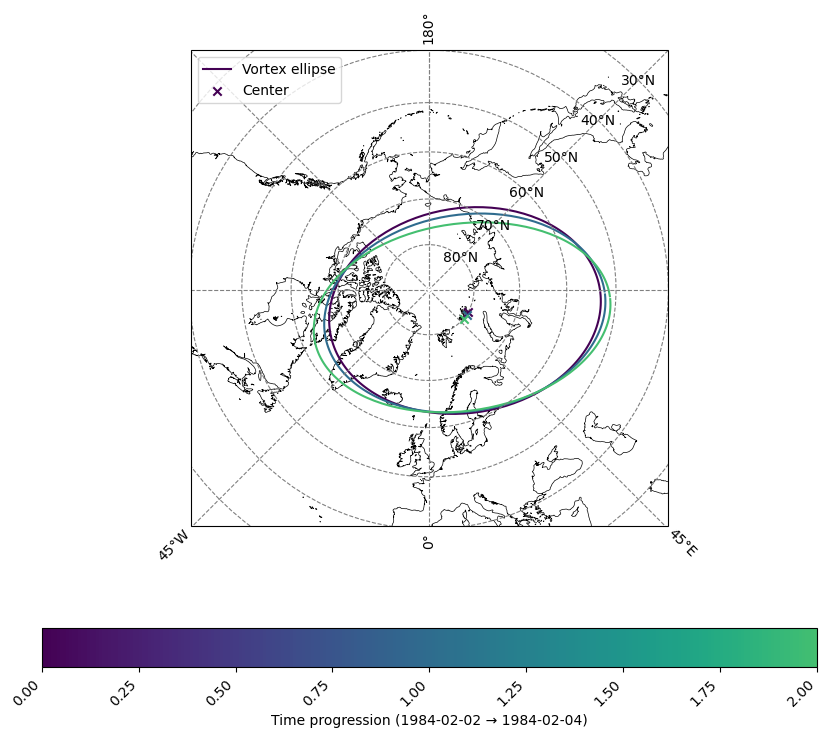

class:  S
split event in time range


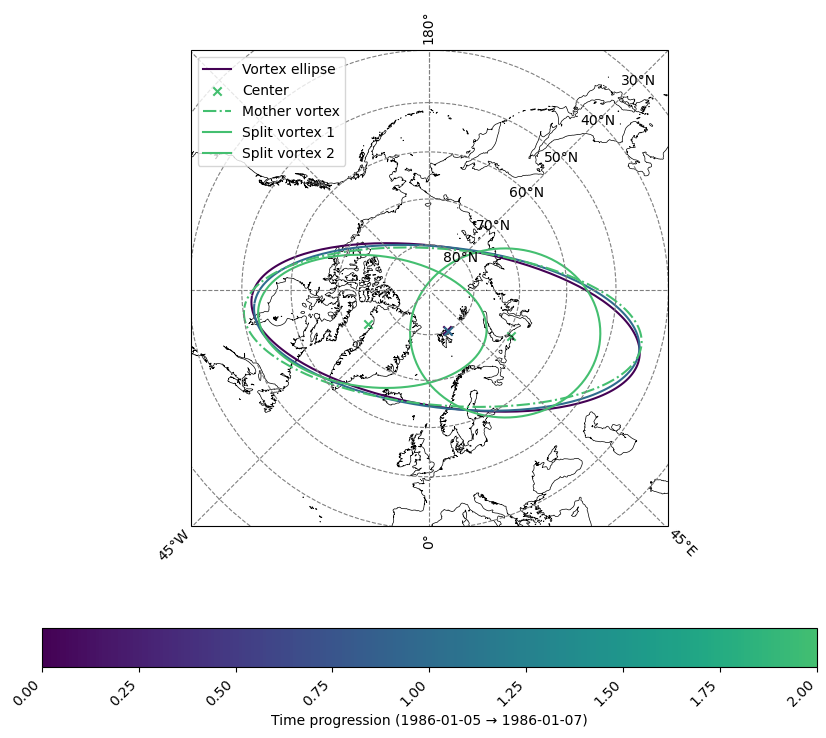

class:  D


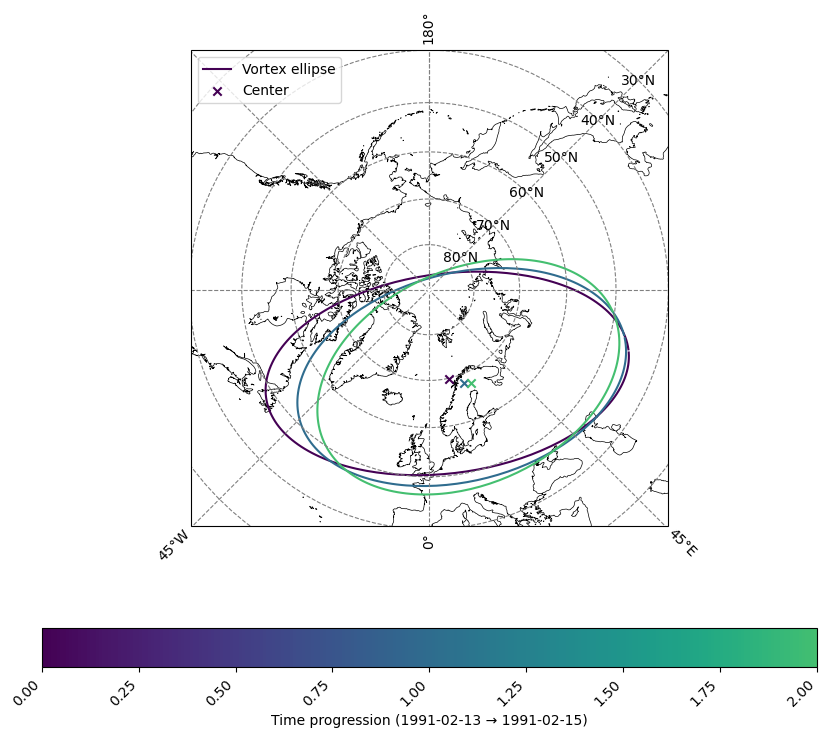

y:  y_ar_latcent_scArea
class:  U


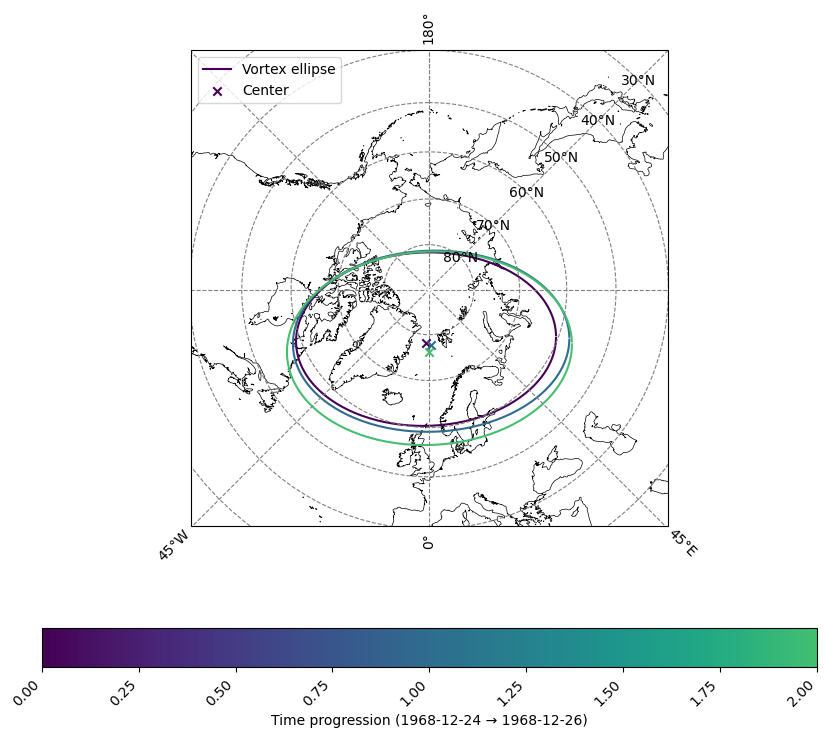

class:  S
split event in time range


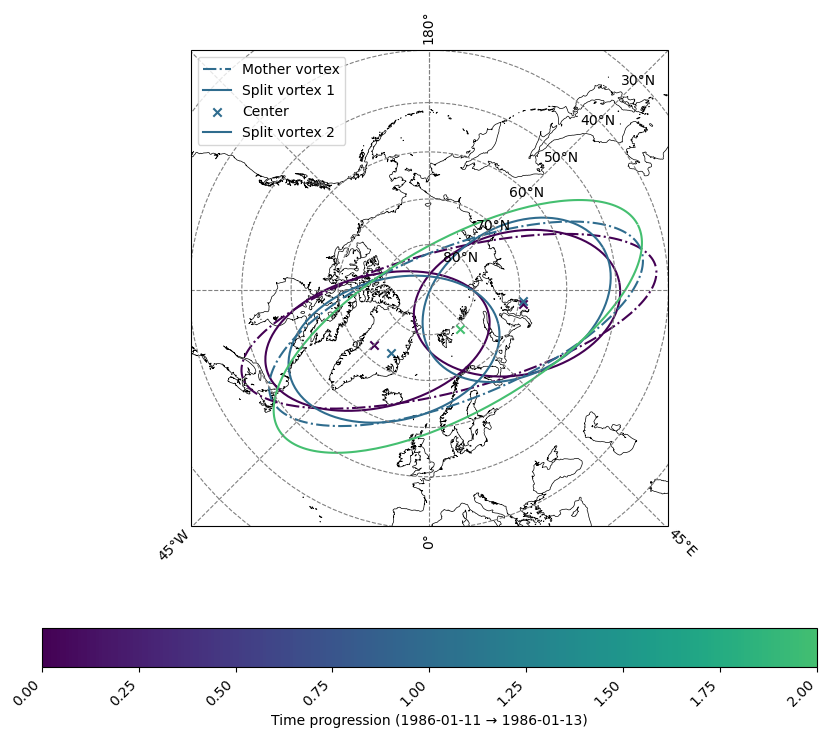

class:  L
MW event in time range


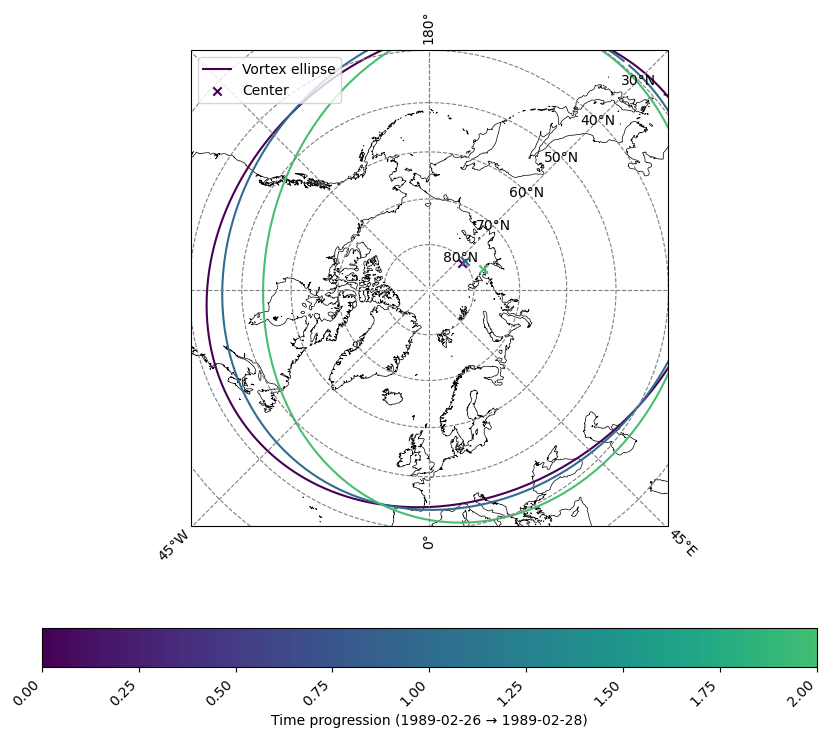

y:  y_ar_latcent_filteredArea
class:  U


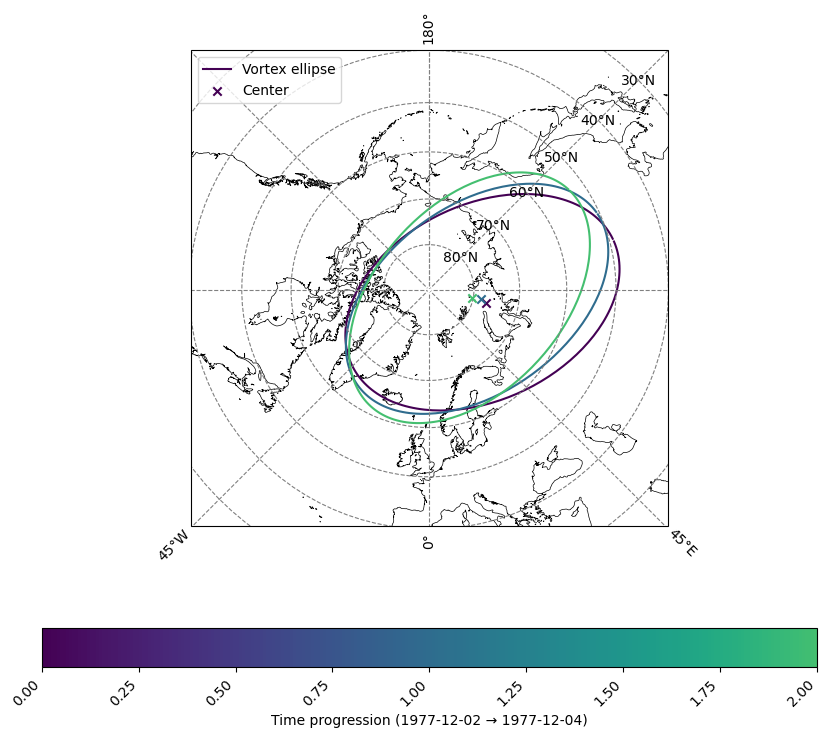

class:  S
split event in time range


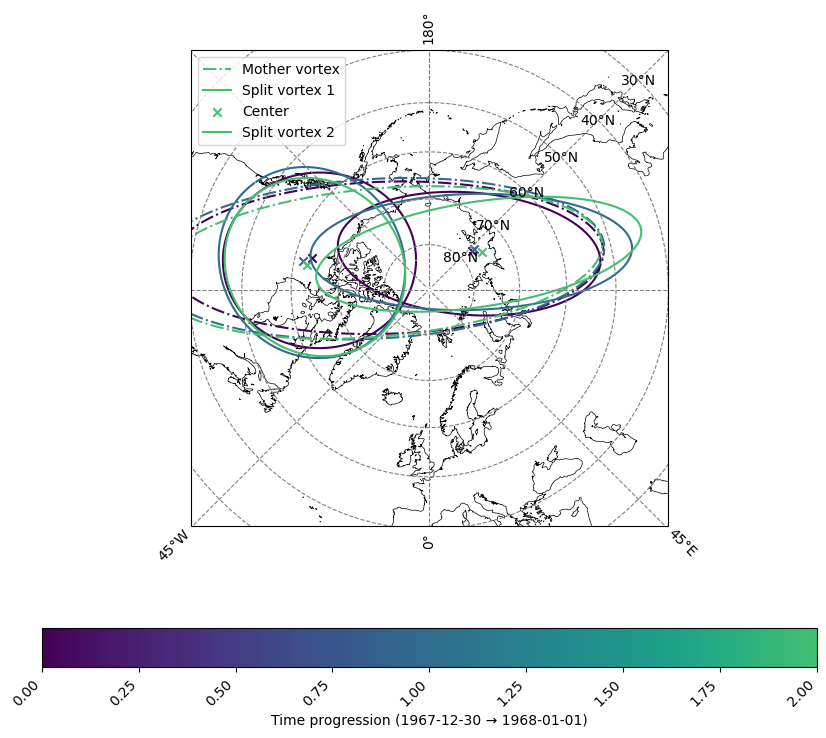

class:  L
MW event in time range


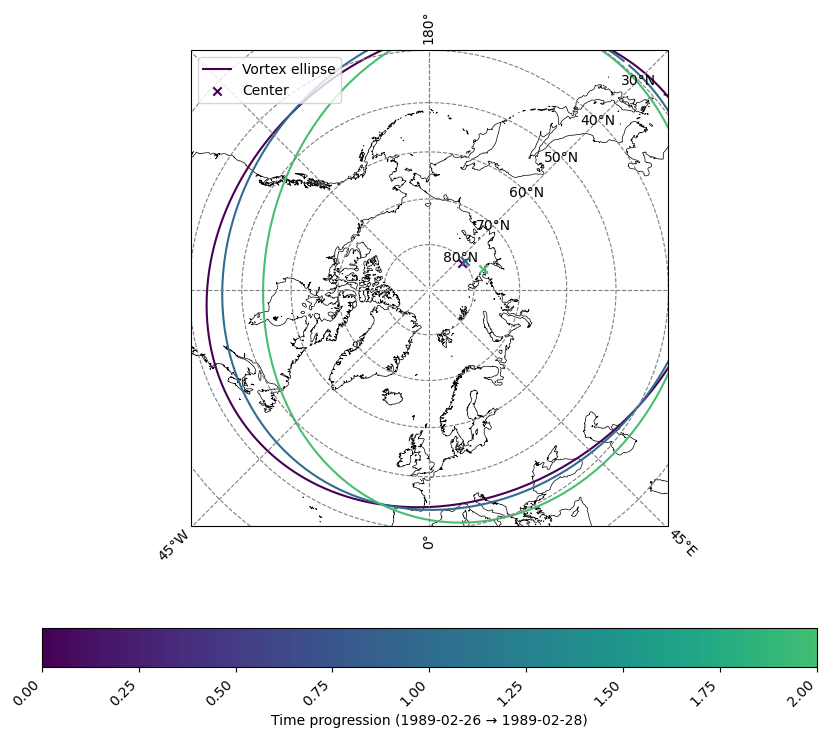

y:  y_ar_latcent_u
class:  U


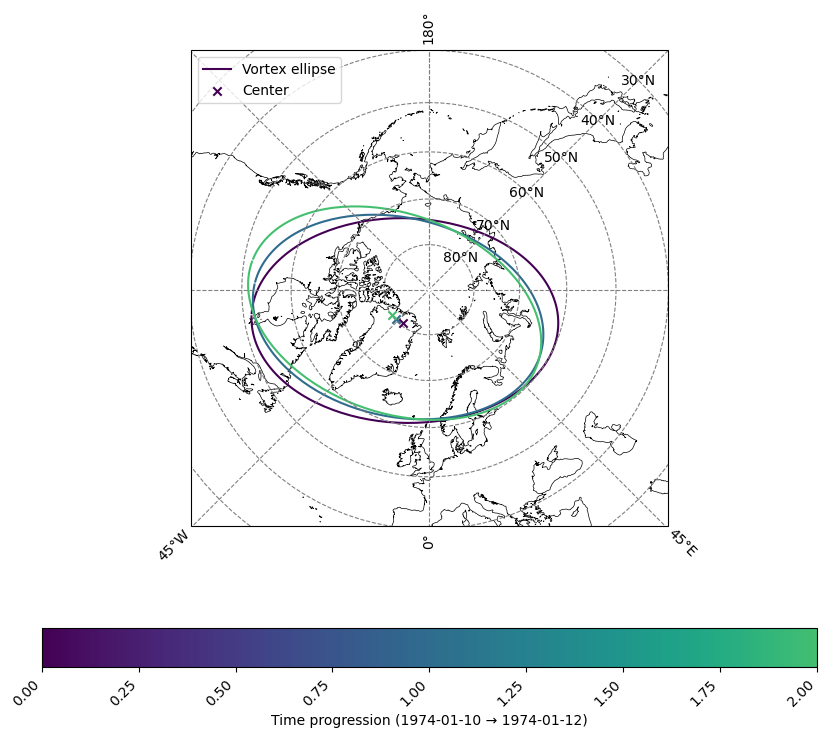

class:  S
split event in time range


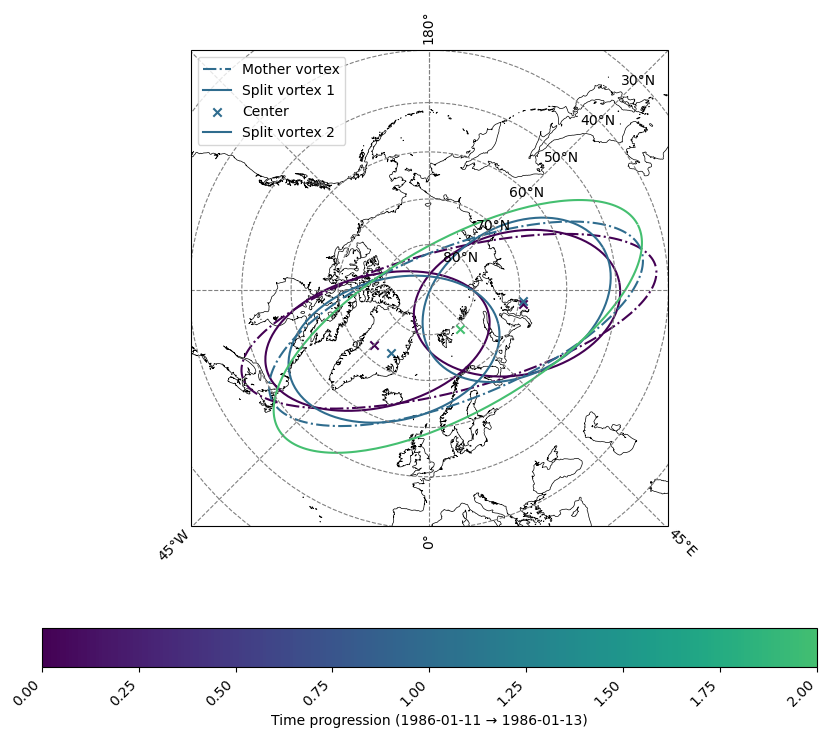

class:  D


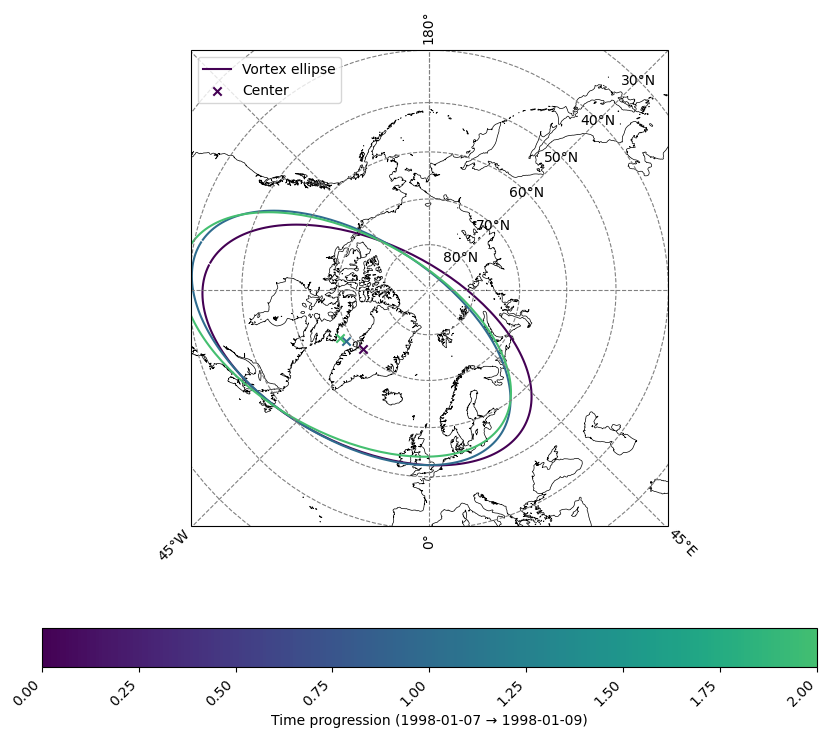

In [25]:
from sklearn.metrics.pairwise import euclidean_distances
from datetime import timedelta

foi = ['ar', 'latcent', 'kurtosis',
       'scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis',
       'ssa_filtered_area', 'ssa_filtered_u']
for y in y_names:
    print('y: ', y)
    for c in era5_hannachi[y].unique():
        print('class: ', c)
        # compute all means
        mean_vec = era5_hannachi[era5_hannachi[y] == c][foi].mean()
        # compute distance of each sample to mean
        dist_mean = euclidean_distances(era5_hannachi[foi], [mean_vec])
        # determine index of sample closest to mean
        mean_idx = dist_mean.argmin()
        # obtain representative sample
        rep_mean = era5_hannachi.iloc[mean_idx]
        # print("Representative mean has class: ", rep_mean[y])

        dates = [rep_mean.string + timedelta(days=i) for i in range(-1, 2)]
        samples = era5_all[era5_all.string.isin(dates)]
        if samples.form.sum() > 0:
            print('split event in time range')
        if samples.MW.sum() > 0:
            print('MW event in time range')

        arctic.plot_polar_stereo(samples, time_col='string', mode='overlay', figsize=(15,15))

# Appendix
For reasons of interest in the data the following was kept.

## Computation of the partial autocorrelation function
The partial autocorrelation function does not exhibit any remarkable perks except for the wind speed reduced to DJFM. The visible peaks correspond closely to the suggested time window of 120 days and indicate a 120d periodic signal in the data.

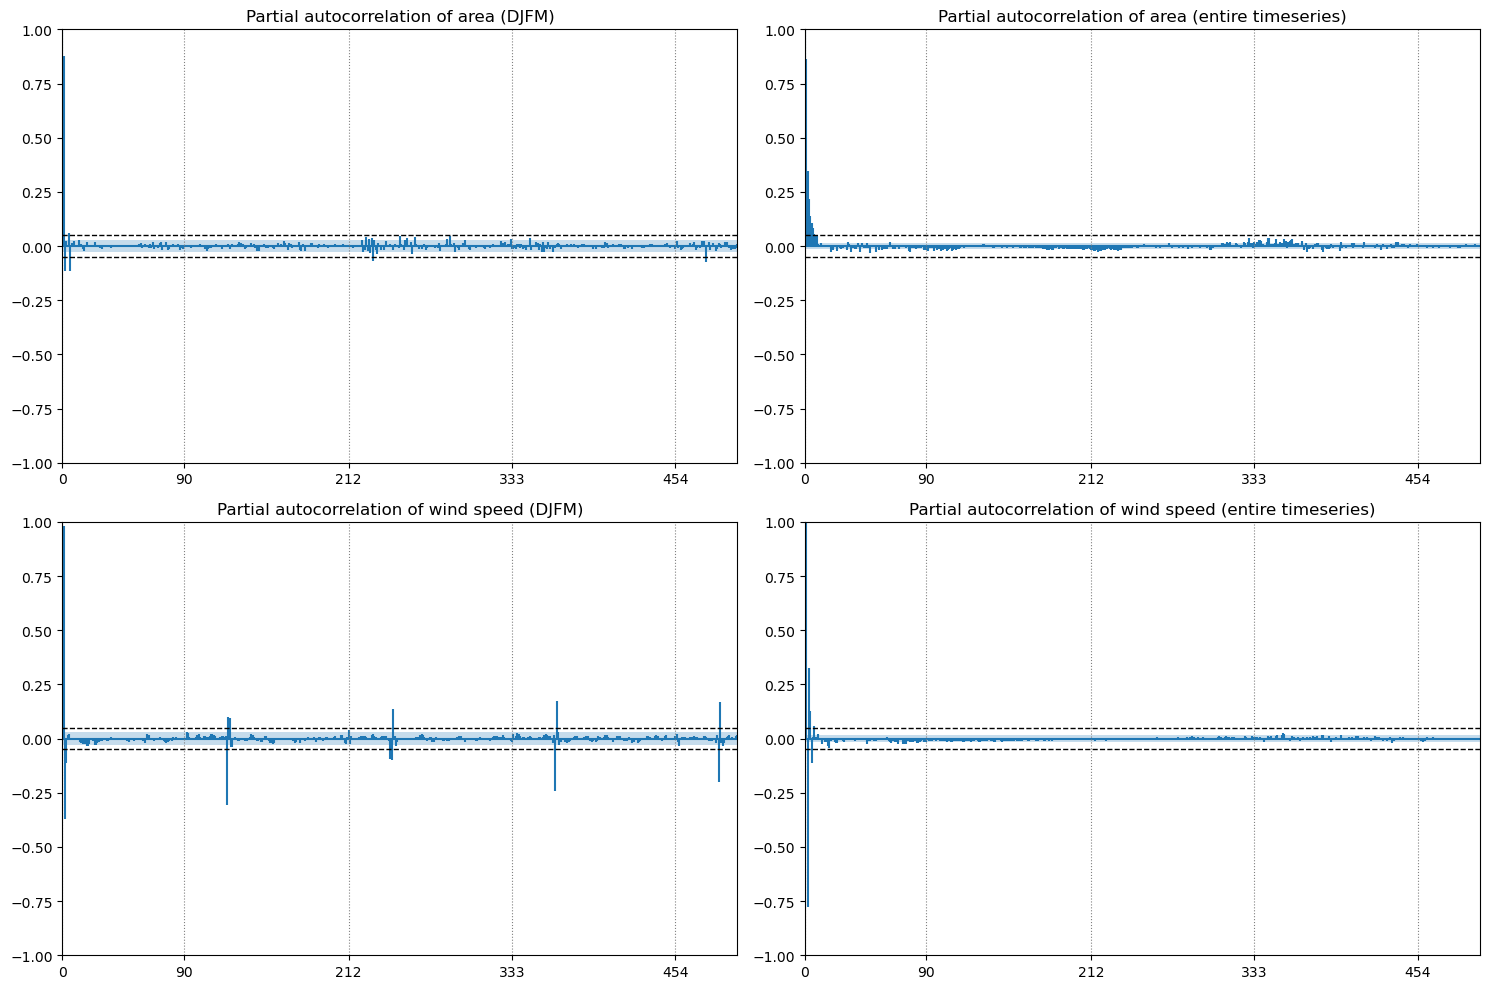

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(2,2, figsize=(15, 10))
ax = ax.flatten()
plot_pacf(era5_hannachi['scaled_area'], lags=500, ax=ax[0], label='PACF scaled area (DJFM)', marker=None)
plot_pacf(era5_all['scaled_area'], lags=500, ax=ax[1], label='PACF scaled area (entire timeseries)', marker=None)
plot_pacf(era5_hannachi['scaled_u'], lags=500, ax=ax[2], label='PACF wind speed (DJFM)', marker=None)
plot_pacf(era5_all['scaled_u'], lags=500, ax=ax[3], label='PACF wind speed (entire timeseries)', marker=None)

ax[0].set_title('Partial autocorrelation of area (DJFM)')
ax[1].set_title('Partial autocorrelation of area (entire timeseries)')
ax[2].set_title('Partial autocorrelation of wind speed (DJFM)')
ax[3].set_title('Partial autocorrelation of wind speed (entire timeseries)')

for i in range(4):
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    ax[i].set_xlim(0, 500)
    ax[i].set_xticks(positions[:5])
    for x in positions:
        ax[i].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()

## Year over Year averages

Below the yearly seasonality is computed with the year over year average as well as the reconstruction of the yearly seasonality with SSA.

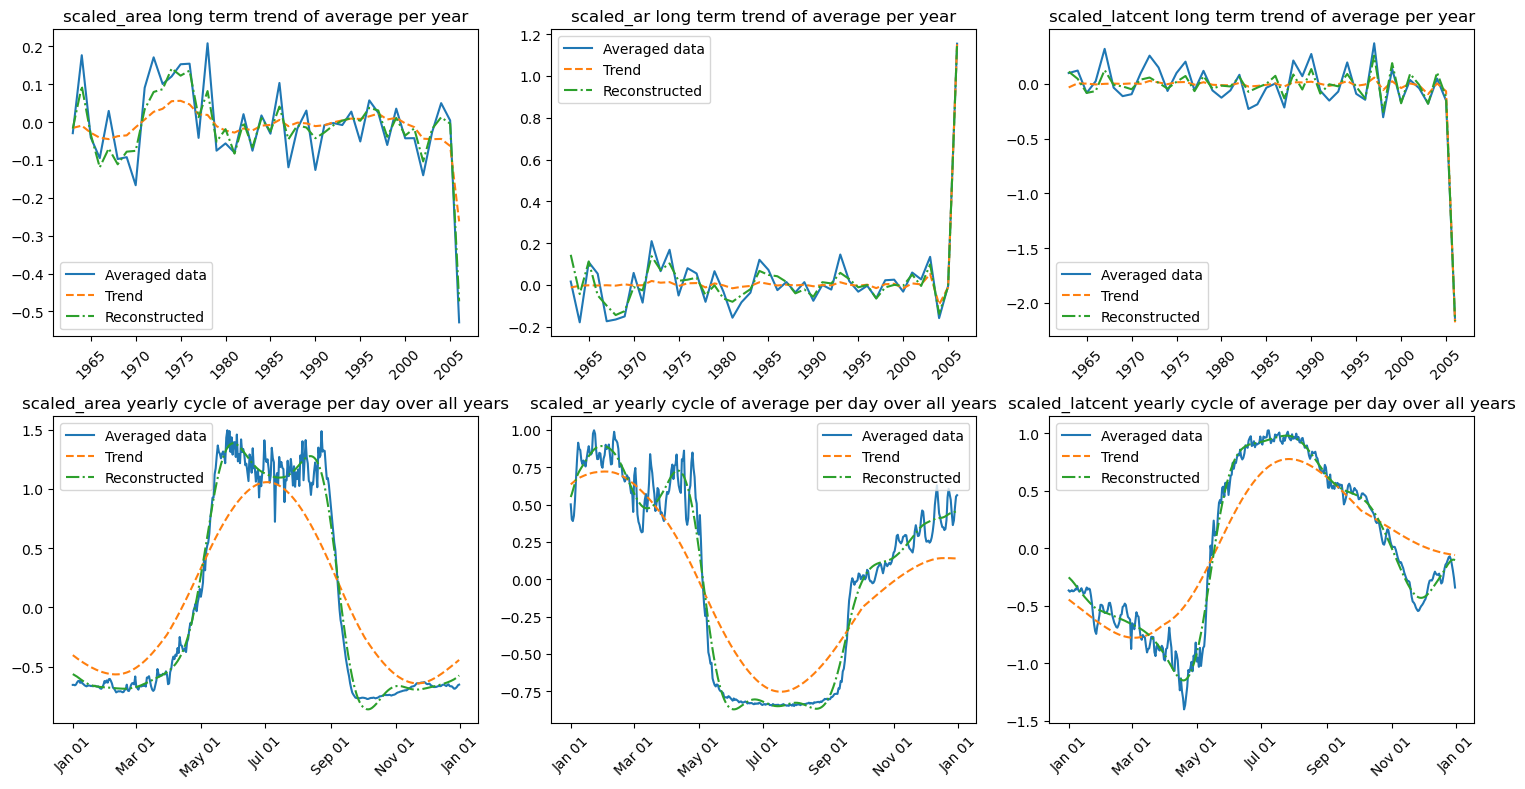

In [27]:
from arctic.workflows.demo import plot_ssa_grid
# Average data
avg_year = era5_all.groupby('year').mean()
avg_year.index = pd.to_datetime(avg_year.index, format='%Y')

avg_day_over_year = era5_all.groupby(['month', 'day']).mean()
avg_day_over_year.index = pd.to_datetime({"year": 2000,  # just a sample year, not displayed in plot
                                          "month": avg_day_over_year.index.get_level_values(0),
                                          "day": avg_day_over_year.index.get_level_values(1)})
# compute SSA
ssa_long_term = SingularSpectrumAnalysis(window_size=10)
ssa_yearly_cycle = SingularSpectrumAnalysis(window_size=90)

long_term_area = ssa_long_term.fit_transform(avg_year['scaled_area'].values.reshape(1, -1))
long_term_ar = ssa_long_term.fit_transform(avg_year['scaled_ar'].values.reshape(1, -1))
long_term_latcent = ssa_long_term.fit_transform(avg_year['scaled_latcent'].values.reshape(1, -1))

year_seasonality_area = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_area'].values.reshape(1, -1))
year_seasonality_ar = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_ar'].values.reshape(1, -1))
year_seasonality_latcent = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_latcent'].values.reshape(1, -1))

# Plot SSA
plot_ssa_grid(
    data_series=[avg_year, avg_day_over_year],
    ssa_results=[[long_term_area, long_term_ar, long_term_latcent],
                 [year_seasonality_area, year_seasonality_ar, year_seasonality_latcent]],
    index_format=['%Y', '%b %d'],
    labels=['scaled_area', 'scaled_ar', 'scaled_latcent'],
    titles=['long term trend of average per year', 'yearly cycle of average per day over all years'],
    used_signals=4
)

## Abbreviations

|          |                                                 |
|---------:|:------------------------------------------------|
|      H11 | Hannachi et al. 2011                            |
|      IAP | Institute for Atmospheric Physics Kühlungsborn  |
|     DJFM | December, January, February, March              |
|       ar | Aspect ratio                                    |
|  latcent | centroid latitude                               |
|      SSW | Sudden Stratospheric Warming                    |
|        S | Cluster of split vortices                       |
|        D | Cluster of displaced vortices                   |
|        L | Cluster of large vortices                       |
|        U | Cluster of undisturbed vortices                 |
|      ACF | Autocorrelation function                        |
|     PACF | Partial Autocorrelation function                |